# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. <br>
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

**Цели исследования:** <br>
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. <br>

**Задачи исследования:** <br>
1. промаркировать уровень финансовой активности постоянных покупателей: «снизилась» / «прежний уровень»;
2. собрать данные по клиентам по следующим группам: 
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом;
    - Признаки, которые описывают продуктовое поведение покупателя: какие товары покупает и как часто;
    - Признаки, которые описывают покупательское поведение клиента: сколько тратил в магазине;
    - Признаки, которые описывают поведение покупателя на сайте: как много страниц просматривает и сколько времени проводит. <br>
3. построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
4. включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;
5. на данных модели и данных о прибыльности клиентов нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Ход исследования:**

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

In [1]:
pip install numba==0.57.1 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap==0.44.1 -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.stats import norm, shapiro

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                   StandardScaler, MinMaxScaler,
                                   LabelEncoder)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
import shap

Зафиксируем константу `RANDOM_STATE`:

In [7]:
RS = 42

## Шаг 1. Загрузка данных

### Загрузка

In [8]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    display('readed from file')
except:
    market_file = pd.read_csv(
        'https://code.s3.yandex.net/datasets/market_file.csv')
    display('readed from server')

display(market_file.head())
market_file.info()

'readed from server'

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [9]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv')
except:
    market_money = pd.read_csv(
        'https://code.s3.yandex.net/datasets/market_money.csv')

display(market_money.head())
market_money.info()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv')
except:
    market_time = pd.read_csv(
        'https://code.s3.yandex.net/datasets/market_time.csv')

display(market_time.head())
market_time.info()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [11]:
try:
    money = pd.read_csv('/datasets/money.csv',sep=';',decimal=',')
except:
    money = pd.read_csv(
        'https://code.s3.yandex.net/datasets/money.csv',sep=';',decimal=',')

display(money.head())
money.info()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В файле 'money.csv' подобрали корректные разделители столбцов и десятичной части.

### Проверка соответствия данных описанию

Взглянем на числовые столбцы таблиц: 

In [12]:
csv = [market_file, market_money, market_time, money]
for t in csv:
    try: display(t.describe())
    except: pass

id  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

Теперь рассмотрим текстовые поля:

In [13]:
for t in csv:
    try: display(t.describe(include='object'))
    except: pass

Покупательская активность Тип сервиса Разрешить сообщать  \
count                       1300        1300               1300   
unique                         2           3                  2   
top              Прежний уровень    стандарт                 да   
freq                         802         914                962   

       Популярная_категория  
count                  1300  
unique                    6  
top        Товары для детей  
freq                    330

Период
count                  3900
unique                    3
top     препредыдущий_месяц
freq                   1300

Период
count            2600
unique              2
top     текущий_месяц
freq             1300

Таблицы имеют разную длину, кратную 1300. Посчитаем значения поля `id` в каждой из них:

In [14]:
for t in csv:
    s=t['id']
    display(f'{s.nunique()}, {s.min()}, {s.max()}, {s.duplicated().sum()}')

'1300, 215348, 216647, 0'

'1300, 215348, 216647, 2600'

'1300, 215348, 216647, 1300'

'1300, 215348, 216647, 0'

Таблицы с временем и выручкой разобьём по периодам:

In [15]:
for t in [market_money, market_time]:
    display(pd.pivot_table(data=t, index='Период', aggfunc='count'))

id  Выручка
Период                            
предыдущий_месяц     1300     1300
препредыдущий_месяц  1300     1300
текущий_месяц        1300     1300

id  минут
Период                       
предыдцщий_месяц  1300   1300
текущий_месяц     1300   1300

Проверим, гипотезу, что в каждой таблице единый перечень `id`, разбитый на периоды:

In [16]:
id_check = pd.DataFrame({
    'm_file': market_file['id'].value_counts(),
    'm_money_0': market_money[
        market_money['Период']=='препредыдущий_месяц']['id'].value_counts(),
    'm_money_1': market_money[
        market_money['Период']=='предыдущий_месяц']['id'].value_counts(),
    'm_money_2': market_money[
        market_money['Период']=='текущий_месяц']['id'].value_counts(),
    'm_time_1': market_time[
        market_time['Период']=='предыдцщий_месяц']['id'].value_counts(),
    'm_time_2': market_time[
        market_time['Период']=='текущий_месяц']['id'].value_counts(),
    'money': money['id'].value_counts()})
id_check['check'] = id_check.sum(axis=1)
display(id_check.sort_values(by='check'))

m_file  m_money_0  m_money_1  m_money_2  m_time_1  m_time_2  money  \
215348       1          1          1          1         1         1      1   
215351       1          1          1          1         1         1      1   
215352       1          1          1          1         1         1      1   
215353       1          1          1          1         1         1      1   
215354       1          1          1          1         1         1      1   
...        ...        ...        ...        ...       ...       ...    ...   
216629       1          1          1          1         1         1      1   
216628       1          1          1          1         1         1      1   
216627       1          1          1          1         1         1      1   
216632       1          1          1          1         1         1      1   
216647       1          1          1          1         1         1      1   

        check  
215348      7  
215351      7  
215352      7  
215353      7  
215354      7  
...       ...  
216629      7  
216628      7  
216627      7  
216632      7  
216647      7  

[1300 rows x 8 columns]

In [17]:
display(id_check['check'].describe())

count    1300.0
mean        7.0
std         0.0
min         7.0
25%         7.0
50%         7.0
75%         7.0
max         7.0
Name: check, dtype: float64

Проверено, что во всех четырёх файлах содержатся 1300 уникальных id клиентов, <br>
в данных о времени на сайте и о выручке id дублируются на 2 и 3 месяца соответственно.

Проверим наличие пропусков в таблицах:

In [18]:
for t in csv:
    display(t.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64

**Выводы** <br>
Данные из всех входящих файлов успешно загружены, подобраны параметры разделителей. <br>
Пропуски в данных не обнаружены, типы числовых полей загрузились корректно. <br>
Ключ для объединения таблиц (id) проверен. Замечены опечатки в текстовых полях.

## Шаг 2. Предобработка данных

Превратим идентификаторы клиентов в индексы таблиц:

In [19]:
m_file = market_file.set_index('id')
m_file.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   
215350                 Снизилась   стандартт                нет   
215351                 Снизилась   стандартт                 да   
215352                 Снизилась   стандартт                нет   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   

        Акционные_покупки Популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   

        Средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
id                                                                            
215348                                   2               1                 5  
215349                                   4               2                 5  
215350                                   2               1                 5  
215351                                   0               6                 4  
215352                                   2               3                 2

In [20]:
display(m_file['Тип сервиса'].value_counts())

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

Исправим выявленную опечатку в значении Уровня сервиса "стандартТ":

In [21]:
m_file['Тип сервиса'] = m_file['Тип сервиса'].replace(
    {'стандартт': 'стандарт'})

Загруженные названия полей длинные, попробуем создать словарь и сократить. <br>
Попутно создадим описательную таблицу, чтобы не забыть исходные названия:

In [22]:
descr=pd.DataFrame({'cols_original':m_file.columns.to_list()})
descr['file'] = 'market_file'
descr['dtype'] = m_file.dtypes.to_list()
descr['nunique'] = m_file.nunique().to_list()
display(descr.head())

cols_original         file    dtype  nunique
0  Покупательская активность  market_file   object        2
1                Тип сервиса  market_file   object        2
2         Разрешить сообщать  market_file   object        2
3         Маркет_актив_6_мес  market_file  float64       41
4       Маркет_актив_тек_мес  market_file    int64        3

Добавим более детальные описания полей: 

In [23]:
descr['txt'] = [
'рассчитанный класс покупательской активности',
'уровень сервиса («премиум» / «стандарт»)',
'можно ли присылать предложения о товаре',
'среднемесячное значение маркетинговых коммуникаций за 6 месяцев',
'количество маркетинговых коммуникаций в текущем месяце',
'дней с момента регистрации на сайте',
'среднемесячная доля покупок по акции от общего числа покупок за 6 месяцев',
'самая популярная категория товаров у покупателя за 6 месяцев',
'сколько в среднем категорий покупатель просмотрел за визит в течение месяца',
'общее число неоплаченных товаров в корзине за 3 месяца',
'число сбоев, которые коснулись покупателя во время посещения сайта',
'среднее количество страниц за один визит на сайт за 3 месяца']

Задаём сокращённые наименования, переставим столбцы:

In [24]:
descr['cols_new'] = [
'activity',
'level',
'spam',
'av_connect_6m',
'n_connect_m0',
'n_days_reg',
'av_share_promo_6m',
'top_cat',
'av_cat_look_m0',
'n_basket_3m',
'n_crush',
'av_page_visit_3m']
seq = ['file', 'cols_new', 'dtype', 'nunique', 'cols_original', 'txt']
descr = descr[seq]
display(descr.head(2))

file  cols_new   dtype  nunique              cols_original  \
0  market_file  activity  object        2  Покупательская активность   
1  market_file     level  object        2                Тип сервиса   

                                            txt  
0  рассчитанный класс покупательской активности  
1      уровень сервиса («премиум» / «стандарт»)

Выгружаем в словарь и переименовываем столбцы первой таблицы:

In [25]:
trans = descr[['cols_original','cols_new']].set_index('cols_original'
                                                     ).to_dict()['cols_new']
m_file = m_file.rename(columns=trans)
m_file.head(2)

activity    level spam  av_connect_6m  n_connect_m0  n_days_reg  \
id                                                                         
215348  Снизилась  премиум   да            3.4             5         121   
215349  Снизилась  премиум   да            4.4             4         819   

        av_share_promo_6m           top_cat  av_cat_look_m0  n_basket_3m  \
id                                                                         
215348               0.00  Товары для детей               6            2   
215349               0.75  Товары для детей               4            4   

        n_crush  av_page_visit_3m  
id                                 
215348        1                 5  
215349        2                 5

Общие данные о покупателях приведены в удобный для работы вид. Дополнительно сохраним таблицу с оригинальным названиями и типами столбцов.

Таблицу с данными о Выручке перестроим, разбив на помесячные столбцы, присвоив им краткие имена: 

In [26]:
m_money = market_money.set_index(['id','Период']).unstack()
display(m_money.head(2))
m_money.columns = ['rev_m1','rev_m2','rev_m0']
m_money = m_money[['rev_m2','rev_m1','rev_m0']]
display(m_money.head(2))

Выручка                                  
Период предыдущий_месяц препредыдущий_месяц текущий_месяц
id                                                       
215348              0.0                 0.0        3293.1
215349           5216.0              4472.0        4971.6

rev_m2  rev_m1  rev_m0
id                            
215348     0.0     0.0  3293.1
215349  4472.0  5216.0  4971.6

Создадим описательную таблицу для столбцов из данных по Выручке:

In [27]:
descr_money=pd.DataFrame({'cols_new':m_money.columns.to_list()})
descr_money['file'] = 'market_money'
descr_money['dtype'] = m_money.dtypes.to_list()
descr_money['nunique'] = m_money.nunique().to_list()
descr_money['cols_original'] = ['Выручка__препредыдущий_месяц',
                                'Выручка__предыдущий_месяц',
                                'Выручка__текущий_месяц']
descr_money['txt'] = ['сумма выручки за предпредыдущий месяц',
                      'сумма выручки за предыдущий месяц',
                      'сумма выручки за текущий месяц']
descr_money = descr_money[seq]
display(descr_money)

file cols_new    dtype  nunique                 cols_original  \
0  market_money   rev_m2  float64      790  Выручка__препредыдущий_месяц   
1  market_money   rev_m1  float64     1122     Выручка__предыдущий_месяц   
2  market_money   rev_m0  float64     1242        Выручка__текущий_месяц   

                                     txt  
0  сумма выручки за предпредыдущий месяц  
1      сумма выручки за предыдущий месяц  
2         сумма выручки за текущий месяц

Таблицу с данными о времени на сайте перестроим, разбив на помесячные столбцы и присвоим им краткие имена: 

In [28]:
m_time = market_time.set_index(['id','Период']).unstack()
display(m_time.head(2))
m_time.columns = ['time_m1','time_m0']
display(m_time.head(2))

минут              
Период предыдцщий_месяц текущий_месяц
id                                   
215348               13            14
215349               12            10

time_m1  time_m0
id                      
215348       13       14
215349       12       10

Описательная таблица для столбцов из данных по времени на сайте:

In [29]:
descr_time=pd.DataFrame({'cols_new':m_time.columns.to_list()})
descr_time['file'] = 'market_time'
descr_time['dtype'] = m_time.dtypes.to_list()
descr_time['nunique'] = m_time.nunique().to_list()
descr_time['cols_original'] = ['минут__предыдцщий_месяц',
                               'минут__текущий_месяц']
descr_time['txt'] = ['времени на сайте за предыдущий месяц',
                     'времени на сайте за текущий месяц']
descr_time = descr_time[seq]
display(descr_time)

file cols_new  dtype  nunique            cols_original  \
0  market_time  time_m1  int64       19  минут__предыдцщий_месяц   
1  market_time  time_m0  int64       20     минут__текущий_месяц   

                                    txt  
0  времени на сайте за предыдущий месяц  
1     времени на сайте за текущий месяц

Таблицу с данными о прибыли также превратим в удобный формат:

In [30]:
display(money.head(2))
money = money.set_index(['id'])
money.columns = ['av_profit_3m']
display(money.head(2))

id  Прибыль
0  215348     0.98
1  215349     4.16

av_profit_3m
id                  
215348          0.98
215349          4.16

Объединим описательные таблицы:

In [31]:
descr_all = pd.concat([descr, descr_money, descr_time], axis='index'
                     ).reset_index(drop=True)
descr_all.loc[len(descr_all.index)] = ['money',
                                       money.columns[0],
                                       money.dtypes[0],
                                       money.nunique()[0],
                                       'Прибыль',
                                       'среднемесячная прибыль за 3 месяца']
display(descr_all)

file           cols_new    dtype  nunique  \
0    market_file           activity   object        2   
1    market_file              level   object        2   
2    market_file               spam   object        2   
3    market_file      av_connect_6m  float64       41   
4    market_file       n_connect_m0    int64        3   
5    market_file         n_days_reg    int64      658   
6    market_file  av_share_promo_6m  float64       42   
7    market_file            top_cat   object        6   
8    market_file     av_cat_look_m0    int64        6   
9    market_file        n_basket_3m    int64       11   
10   market_file            n_crush    int64       10   
11   market_file   av_page_visit_3m    int64       20   
12  market_money             rev_m2  float64      790   
13  market_money             rev_m1  float64     1122   
14  market_money             rev_m0  float64     1242   
15   market_time            time_m1    int64       19   
16   market_time            time_m0    int64       20   
17         money       av_profit_3m  float64      400   

                          cols_original  \
0             Покупательская активность   
1                           Тип сервиса   
2                    Разрешить сообщать   
3                    Маркет_актив_6_мес   
4                  Маркет_актив_тек_мес   
5                          Длительность   
6                     Акционные_покупки   
7                  Популярная_категория   
8   Средний_просмотр_категорий_за_визит   
9    Неоплаченные_продукты_штук_квартал   
10                       Ошибка_сервиса   
11                     Страниц_за_визит   
12         Выручка__препредыдущий_месяц   
13            Выручка__предыдущий_месяц   
14               Выручка__текущий_месяц   
15              минут__предыдцщий_месяц   
16                 минут__текущий_месяц   
17                              Прибыль   

                                                  txt  
0        рассчитанный класс покупательской активности  
1            уровень сервиса («премиум» / «стандарт»)  
2             можно ли присылать предложения о товаре  
3   среднемесячное значение маркетинговых коммуник...  
4   количество маркетинговых коммуникаций в текуще...  
5                 дней с момента регистрации на сайте  
6   среднемесячная доля покупок по акции от общего...  
7   самая популярная категория товаров у покупател...  
8   сколько в среднем категорий покупатель просмот...  
9   общее число неоплаченных товаров в корзине за ...  
10  число сбоев, которые коснулись покупателя во в...  
11  среднее количество страниц за один визит на са...  
12              сумма выручки за предпредыдущий месяц  
13                  сумма выручки за предыдущий месяц  
14                     сумма выручки за текущий месяц  
15               времени на сайте за предыдущий месяц  
16                  времени на сайте за текущий месяц  
17                 среднемесячная прибыль за 3 месяца

С учтом переноса идентификаторов в индекс, проверим наличие полных дубликатов в таблицах:

In [32]:
new_df = [m_file, m_money, m_time, money]
for t in new_df:
    display(t.duplicated().sum())

11

21

1022

900

В каждой таблице выявлены дубликаты. Проверим, есть ли дубликаты при объединении:

In [33]:
df = pd.concat(new_df[0:3], axis='columns')
display(df.duplicated().sum())
df_all = pd.concat(new_df, axis='columns')
display(df_all.duplicated().sum())

11

0

При объединении трёх таблиц `market_file`, `market_money` и `market_time` выявлены **11** дубликатов (при этом с различными, уникальными идентификаторами).  <br>
То есть это всё же разные клиенты, но с одинаковыми метриками поведения, активности и выручки. <br>
Однако, значения среднемесячной прибыли у них различные. <br>
На этом этапе сохраним все данные, дубликаты удалять не будем.

In [34]:
display(df[df.duplicated()])

activity     level spam  av_connect_6m  n_connect_m0  n_days_reg  \
id                                                                          
215895  Снизилась  стандарт  нет            4.4             5         517   
215896  Снизилась  стандарт  нет            4.3             4         460   
215897  Снизилась  стандарт   да            3.9             4         627   
215898  Снизилась  стандарт   да            5.5             4         703   
215899  Снизилась  стандарт  нет            5.0             4         136   
215900  Снизилась  стандарт   да            4.8             4         907   
215901  Снизилась  стандарт  нет            3.9             5         600   
215902  Снизилась  стандарт   да            3.3             3         871   
215903  Снизилась  стандарт   да            5.6             5         574   
215904  Снизилась   премиум   да            5.5             5         982   
215905  Снизилась  стандарт   да            4.3             4         324   

        av_share_promo_6m                               top_cat  \
id                                                                
215895               0.23                      Товары для детей   
215896               0.16        Техника для красоты и здоровья   
215897               0.24                      Товары для детей   
215898               0.14  Мелкая бытовая техника и электроника   
215899               0.27                      Товары для детей   
215900               0.30                 Косметика и аксесуары   
215901               0.17                     Домашний текстиль   
215902               0.20        Техника для красоты и здоровья   
215903               0.28                     Домашний текстиль   
215904               0.94  Мелкая бытовая техника и электроника   
215905               0.14        Техника для красоты и здоровья   

        av_cat_look_m0  n_basket_3m  n_crush  av_page_visit_3m  rev_m2  \
id                                                                       
215895               1            2        5                11  4382.0   
215896               2            1        3                 6  4822.0   
215897               3            3        7                 8  4460.0   
215898               2            1        3                 7  4346.0   
215899               3            4        4                17  5230.0   
215900               2            1        1                 6  5241.0   
215901               1            7        4                10  5047.0   
215902               2            4        2                17  4818.0   
215903               3            2        3                 9  4483.0   
215904               3            1        8                10  5204.0   
215905               2            7        4                 4  5160.0   

        rev_m1  rev_m0  time_m1  time_m0  
id                                        
215895  3130.0  4345.5       11       12  
215896  4828.0  4952.8       13        9  
215897  5004.5  5606.4       17       12  
215898  3428.0  4353.6       18       11  
215899  4998.0  5329.5       11       18  
215900  5005.5  4931.4       13       14  
215901  4606.0  4353.8       18       20  
215902  5439.0  6107.2       17        8  
215903  4502.0  4615.1       16        6  
215904  5118.5  5174.4       18       19  
215905  5314.0  5310.1       18       20

**Выводы** <br>
В рамках предобработки данных таблицы приведены к удобному формату, <br>
идентификаторы выведены в индексы таблиц, сохранена описательная таблица данных. <br>
В данных нет пропусков. Дубликаты выявлены, но пока сохранены.

## Шаг 3. Исследовательский анализ данных

### Категориальные признаки

Рассмотрим распределения категориальных признаков в данных о поведении покупателей на сайте, о коммуникациях с покупателем и его продуктовом поведении:

In [35]:
def pivo (param, df=m_file):
    param_t = df[param].value_counts().to_frame()
    param_t['share'] = (param_t[param]/param_t[param].sum()).round(3)
    display(param_t)
    plt.rcParams['figure.figsize'] = (4, 4)
    param_t[param].plot.pie(legend=False, colormap='summer')
    name = descr_all.loc[descr_all['cols_new']==param, 'cols_original'
                        ].to_list()[0]
    plt.title(f"{param} / {name}")
    plt.ylabel('')
    plt.show();

In [36]:
encode_list = descr_all.loc[(descr_all['file']=='market_file'
                            )&(descr_all['dtype']=='object'
                              ),'cols_new'].to_list()
encode_list

['activity', 'level', 'spam', 'top_cat']

activity  share
Прежний уровень       802  0.617
Снизилась             498  0.383

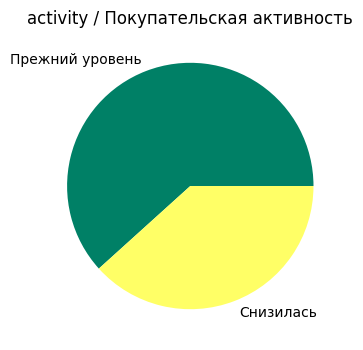

In [37]:
i=0
pivo(encode_list[i])

Целевой признак (рассчитанный класс покупательской активности) распределён неравномерно: 62% / 38%. <br>
Это придётся учесть при стратификации выборок для обучения.

level  share
стандарт    924  0.711
премиум     376  0.289

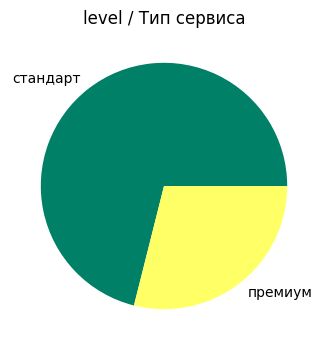

In [38]:
i+=1
pivo(encode_list[i])

Тип / Уровень сервиса также как и целевой признак, является бинарным. <br>
В этом признаке также наблюдается дисбаланс (71% / 29%)

spam  share
да    962   0.74
нет   338   0.26

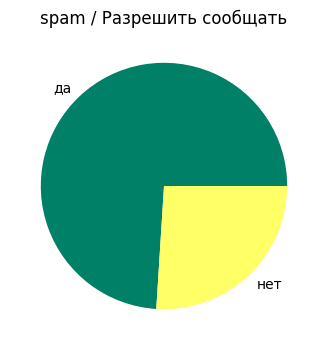

In [39]:
i+=1
pivo(encode_list[i])

Разрешения на маркетинговые коммуникации у клиентов также являются бинарным признаком. <br>
По данному признаку также наблюдается дисбаланс (74% / 26%)

*Любопытно, как пересекается эта четверть в первых трёх показателях?*

In [40]:
m_file.pivot_table(values='top_cat', index='activity', 
                   columns=['level', 'spam'], 
                   aggfunc='count', margins=True)

level           премиум     стандарт        All
spam                 да нет       да  нет      
activity                                       
Прежний уровень     182  24      409  187   802
Снизилась           145  25      226  102   498
All                 327  49      635  289  1300

*Явного совпадения нет, детальнее рассмотрим на этапе корреляционного анализа.*

top_cat  share
Товары для детей                          330  0.254
Домашний текстиль                         251  0.193
Косметика и аксесуары                     223  0.172
Техника для красоты и здоровья            184  0.142
Мелкая бытовая техника и электроника      174  0.134
Кухонная посуда                           138  0.106

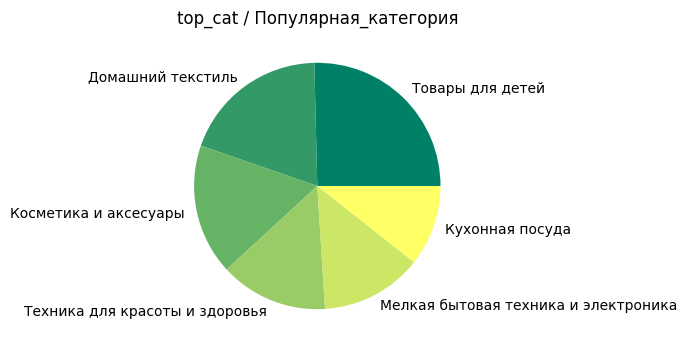

In [41]:
i+=1
pivo(encode_list[i])

"Самая популярная категория товаров у покупателя за 6 месяцев" - более равномерно распределённый категориальный НЕпорядковый признак.

### Количественные признаки

In [42]:
numer_list = descr_all.loc[(descr_all['file']=='market_file'
                            )&((descr_all['dtype']=='int64')|
                               (descr_all['dtype']=='float64')
                              ),'cols_new'].to_list()
numer_list

['av_connect_6m',
 'n_connect_m0',
 'n_days_reg',
 'av_share_promo_6m',
 'av_cat_look_m0',
 'n_basket_3m',
 'n_crush',
 'av_page_visit_3m']

In [43]:
def desc (param, df=m_file):
    display(df[param].describe().round(2).to_frame().T)
    plt.rcParams['figure.figsize'] = (15, 3)
    df[param].hist(color='green',bins=10)
    name = descr_all.loc[descr_all['cols_new']==param, 'cols_original'
                        ].to_list()[0]
    plt.title(f"{param} / {name}")
    plt.ylabel('клиентов')
    plt.show();
    plt.rcParams['figure.figsize'] = (15, 2)
    sns.boxplot(x=df[param], orient='h', color='green')
    plt.show();

count  mean   std  min  25%  50%  75%  max
av_connect_6m  1300.0  4.25  1.01  0.9  3.7  4.2  4.9  6.6

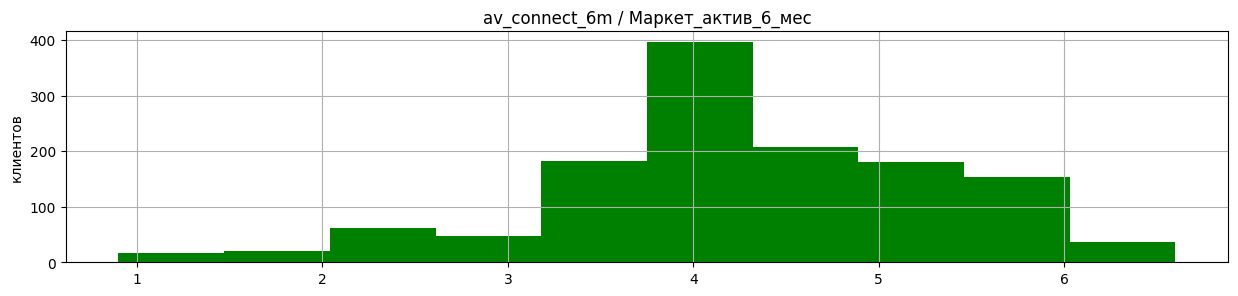

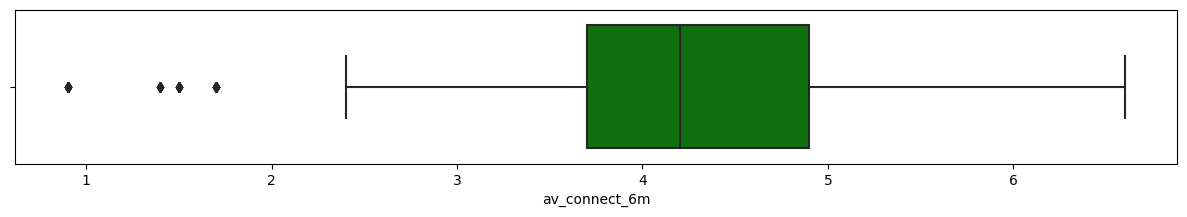

In [44]:
i=0
desc(numer_list[i])

Показатель среднемесячного количества маркетинговых коммуникаций за 6 месяцев варьируется от 2.3 до 6.5. Значения меньше 2 - выбросы. Означает, что каждому клиенту в месяц компания направляет 2-7 предложения. Существенно, при том что 26% клиентов отказались от рассылок. 

count  mean  std  min  25%  50%  75%  max
n_connect_m0  1300.0  4.01  0.7  3.0  4.0  4.0  4.0  5.0

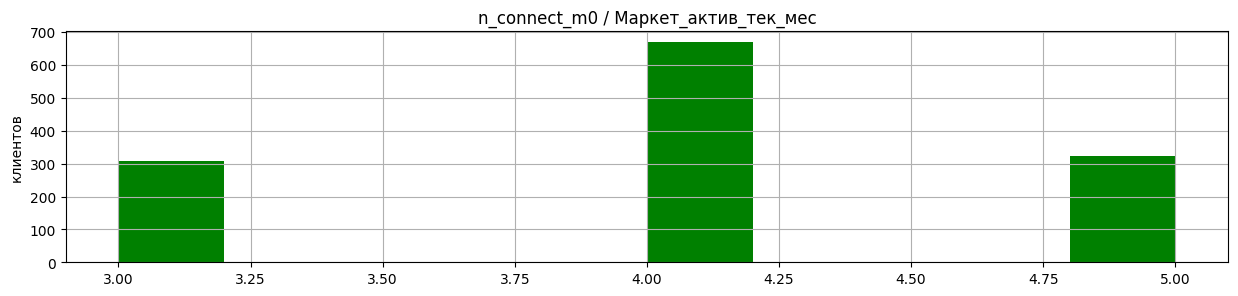

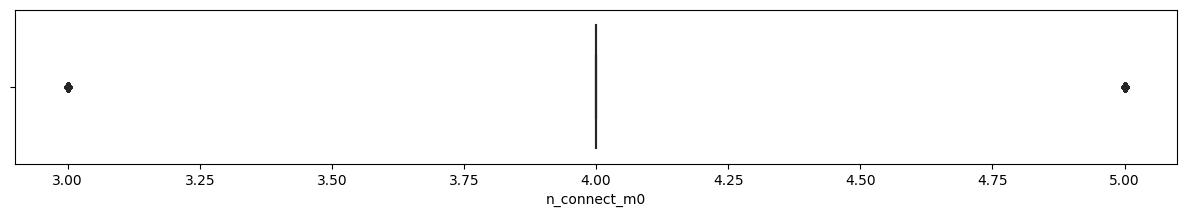

In [45]:
i+=1
desc(numer_list[i])

In [46]:
display(m_file['n_connect_m0'].value_counts().sort_index().to_frame())

n_connect_m0
3           308
4           669
5           323

За текущий месяц каждому клиенту поступило от 3 до 5 маркетинговых предложения. Мода и медиана равна 4.

count   mean     std    min    25%    50%    75%     max
n_days_reg  1300.0  601.9  249.86  110.0  405.5  606.0  806.0  1079.0

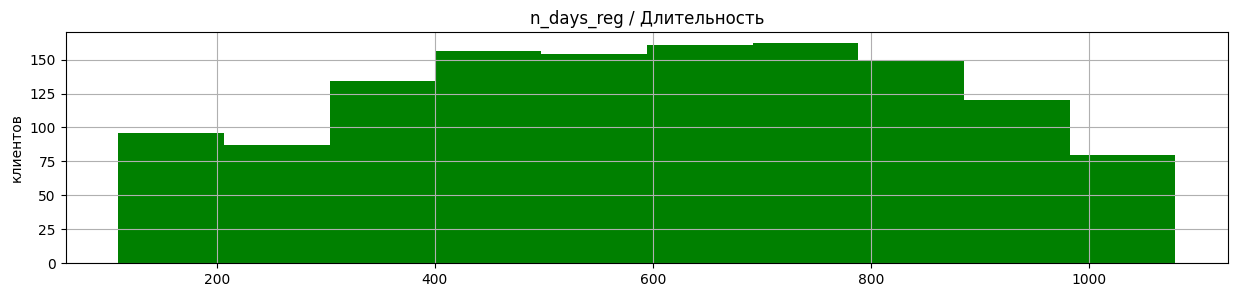

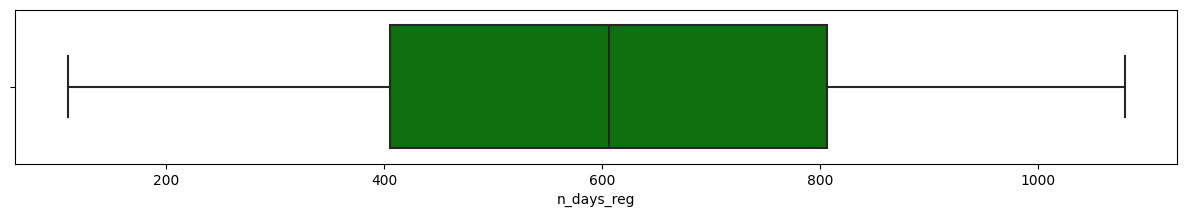

In [47]:
i+=1
desc(numer_list[i])

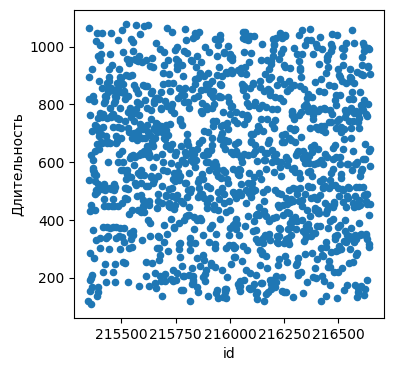

In [48]:
plt.rcParams['figure.figsize'] = (4, 4)
m_file['n_days_reg'].to_frame().reset_index(drop=False).plot(
    kind='scatter', x='id', y='n_days_reg')
plt.ylabel(descr_all.loc[descr_all['cols_new']==numer_list[i], 
                          'cols_original'].to_list()[0])
plt.show();

Все клиенты в данных зарегистрированы от 4 месяцев до 3 лет. <br>
Забавно, но № id не связан с длительностью регистрации)))

count  mean   std  min   25%   50%  75%   max
av_share_promo_6m  1300.0  0.32  0.25  0.0  0.17  0.24  0.3  0.99

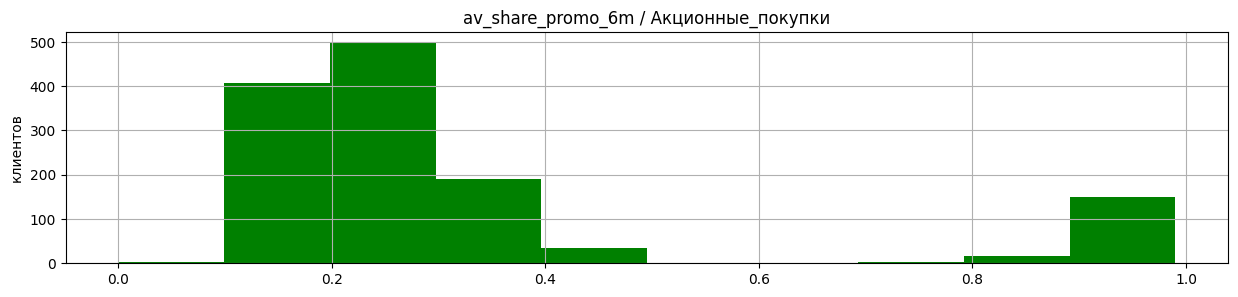

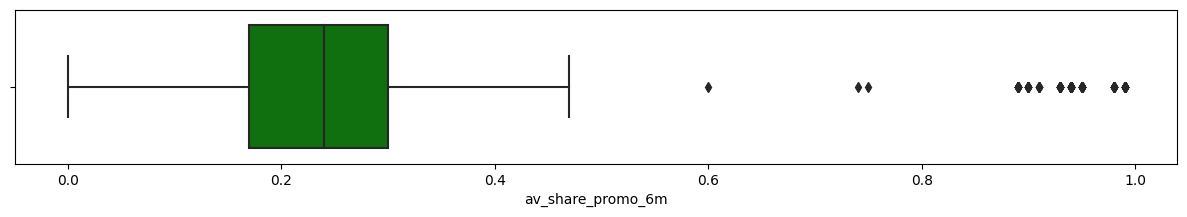

In [49]:
i+=1
desc(numer_list[i])

Доля акционных покупок за 6 месяцев у большинства клиентов выше нуля и у 70% не превышает 0.3. <br>
Выделяются единичные выбросы, чья доля акционных покупок от 60% и доходит до 99%.  <br>
"Акционер" - значит покупаю по акции)

count  mean   std  min  25%  50%  75%  max
av_cat_look_m0  1300.0  3.27  1.36  1.0  2.0  3.0  4.0  6.0

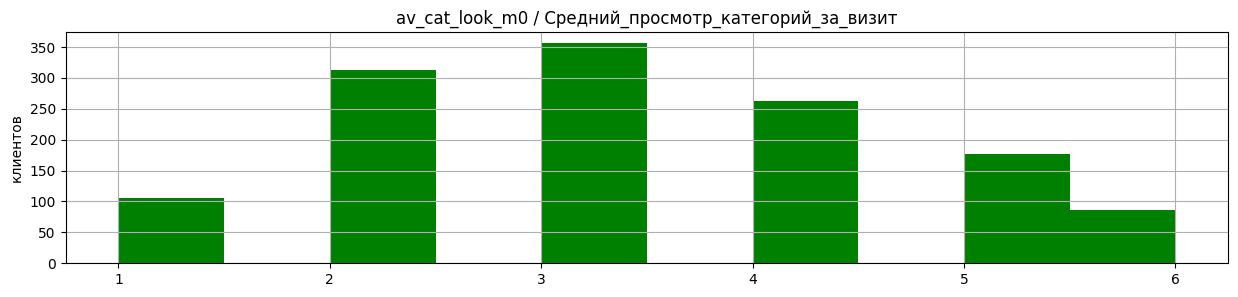

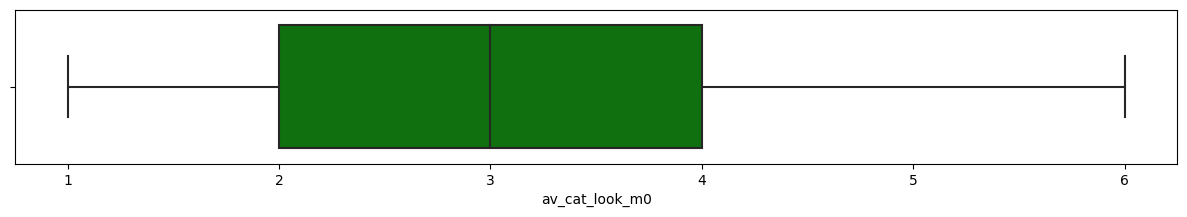

In [50]:
i+=1
desc(numer_list[i])

В текущем месяце каждый клиент заходит на сайт и за один визит просматривает товары до 6 категорий. <br>
С учётом диапазона 6 значений категориального признака "Популярная категория", можно предположить, что в магазине всего 6 категорий.

count  mean   std  min  25%  50%  75%   max
n_basket_3m  1300.0  2.84  1.97  0.0  1.0  3.0  4.0  10.0

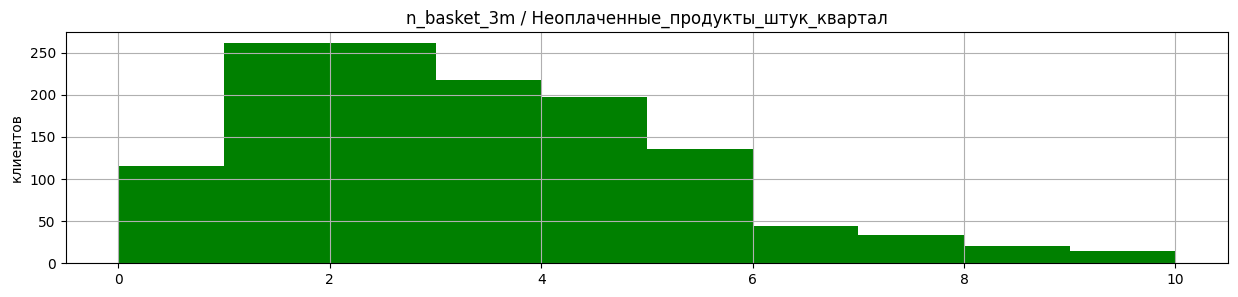

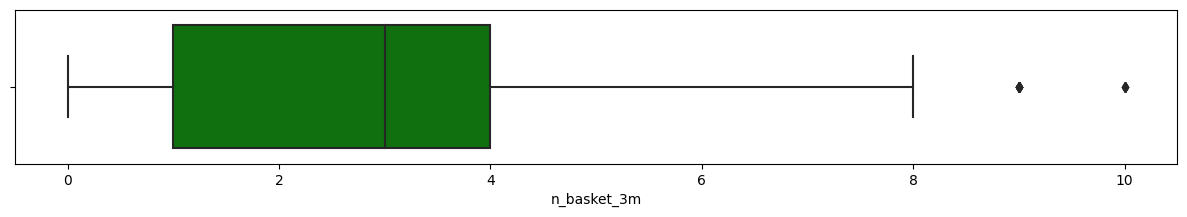

In [51]:
i+=1
desc(numer_list[i])

У почти каждого клиента встречаются ситуации, когда в корзине остаётся несколько неподтверждённых заказов. <br>
В среднем, в корзине остаётся 3 товара. Больше 8 товаров обычно за квартал не накапливается. 

count  mean   std  min  25%  50%  75%  max
n_crush  1300.0  4.19  1.96  0.0  3.0  4.0  6.0  9.0

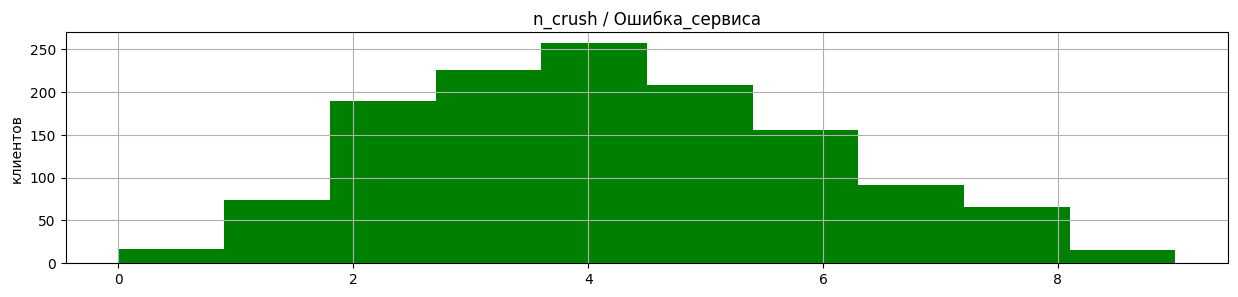

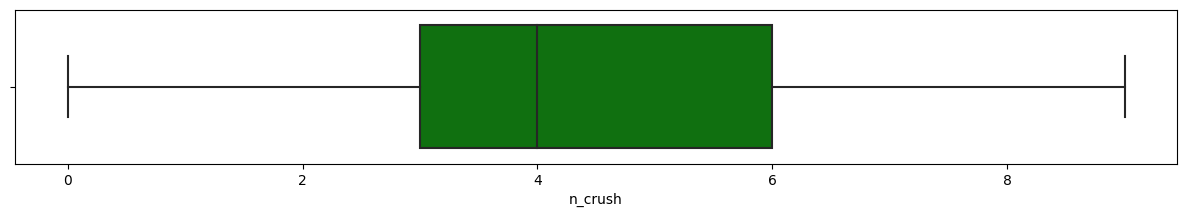

In [52]:
i+=1
desc(numer_list[i])

Сбои на сайте случаются регулярно - почти каждый пользователь сталкивался с ошибками при посещении сайта. Распределение количества ошибок похоже на нормальное, среднее и медианное количество ошибок равно четырём. Правда, из описания данных не совсем понятно - четыре ошибки за последний визит? и так каждое посещение? Замечает ли пользователь эти ошибки? Если бы я на странице интернет-магазина за сеанс повстречал бы четыре ошибки, я в него очень не скоро зашёл бы вновь, может через годик-другой.

count  mean   std  min  25%  50%   75%   max
av_page_visit_3m  1300.0  8.18  3.98  1.0  5.0  8.0  11.0  20.0

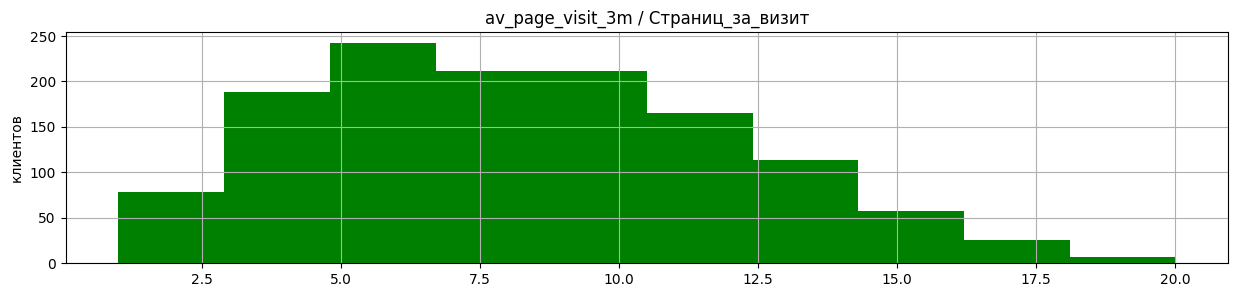

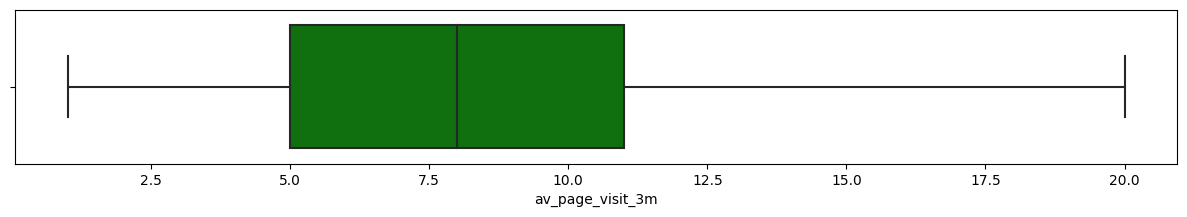

In [53]:
i+=1
desc(numer_list[i])

Среднее количество посещённых страниц за визит за последние 3 месяца: <br>
различные пользователи просматривают от 1 до 20 страниц на сайте, Среднее и медианное значение этого показателя на уровне 8 страиц за визит. Половина пользователей находятся в диапазоне от 5 до 11 страниц. <br>
К сожалению, как и многие другие исходные показатели, этот - среднее значение за 3 месяца. А ведь именно динамические показатели (которые позволяют сравнивать активность во времени) позволили бы оценить изменение активности и подсказать изменение поведение клиентов. Отличается ли текущее значение среднего количества посещённых страниц у клиента  от его же прошлого значения - неизвестно...

### Выручка

In [54]:
display(m_money.describe().round(2))

rev_m2   rev_m1     rev_m0
count  1300.00  1300.00    1300.00
mean   4825.21  4936.92    5314.96
std     405.98   739.60    2939.71
min       0.00     0.00    2758.70
25%    4583.00  4496.75    4706.05
50%    4809.00  5005.00    5179.95
75%    5053.50  5405.62    5761.72
max    5663.00  6869.50  106862.20

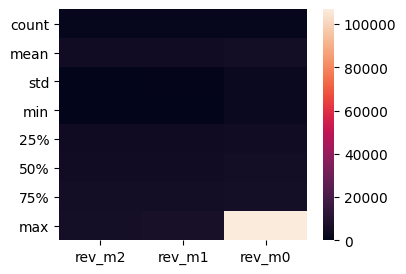

In [55]:
plt.rcParams['figure.figsize'] = (4, 3)
sns.heatmap(m_money.describe());

Выявлена аномалия в данных о выручке: при максимальных значениях в month-2 и month-1 до 7 тыс. руб., в текущем месяце максимум составил 107 тыс. руб. <br>
Проверим, сколько клиентов со столь крупными тратами:

In [56]:
limit = 10000
display(m_money[m_money['rev_m0'] > limit])

rev_m2  rev_m1    rev_m0
id                              
215380  5051.0  6077.0  106862.2

Клиентов, потративших в текущем месяце больше 10 тыс. руб. (107 тыс. руб.) всего один. <br>
Посчитаем его "выбросом" и поосторожимся включать его в данные для обучения модели.

rev_m2   rev_m1   rev_m0
count  1299.00  1299.00  1299.00
mean   4825.03  4936.04  5236.79
std     406.09   739.21   835.47
min       0.00     0.00  2758.70
25%    4583.00  4496.50  4705.50
50%    4809.00  5004.50  5179.60
75%    5054.00  5404.25  5759.95
max    5663.00  6869.50  7799.40

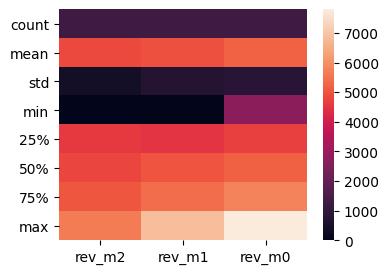

In [57]:
display(m_money[m_money['rev_m0'] < limit].describe().round(2))
plt.rcParams['figure.figsize'] = (4, 3)
sns.heatmap(m_money[m_money['rev_m0'] < limit].describe());

Из представленных данных по выручке заметно, что клиенты со временем приносят всё больше выручки каждый месяц: растут Среднея, Медианное и Максимальное значения. Также возрастает и разброс - увеличивается значение стандартного отклонения.

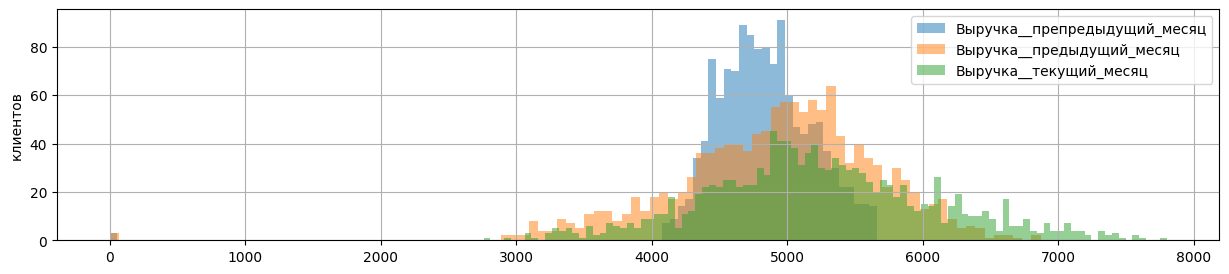

In [58]:
names = descr_all[descr_all['file']=='market_money']['cols_original'].to_list()
plt.rcParams['figure.figsize'] = (15, 3)
for i in m_money.columns:
    m_money[m_money[i]<limit][i].hist(bins=100, legend=True, alpha=0.5)
plt.legend(names)    
plt.ylabel('клиентов')
plt.show();

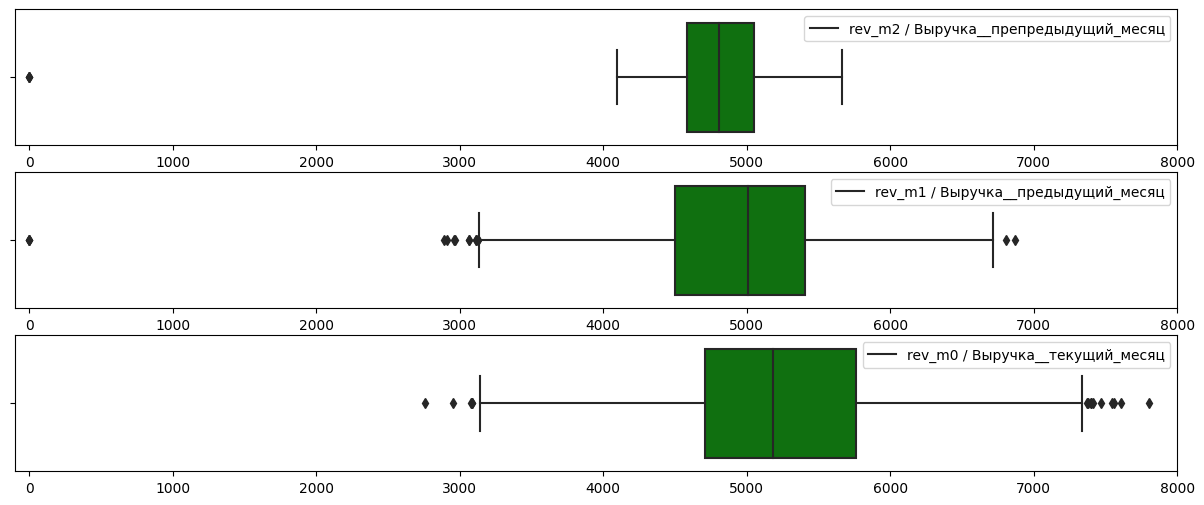

In [59]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots(nrows=3, ncols=1)
names = descr_all[descr_all['file']=='market_money']['cols_original'].to_list()
_=0
for i in m_money.columns:   
    plt.subplot(3,1,_+1)
    ax=sns.boxplot(x=m_money[m_money[i]<limit][i], orient='h', color='green')
    ax.set_xlim(-100, 8000)
    plt.legend({f'{i} / {names[_]}'})
    plt.xlabel('')
    _+=1
plt.show;

### Минут на сайте

In [60]:
display(m_time.describe().round(2).T)

count   mean   std  min   25%   50%   75%   max
time_m1  1300.0  13.47  3.93  5.0  11.0  13.0  17.0  23.0
time_m0  1300.0  13.20  4.22  4.0  10.0  13.0  16.0  23.0

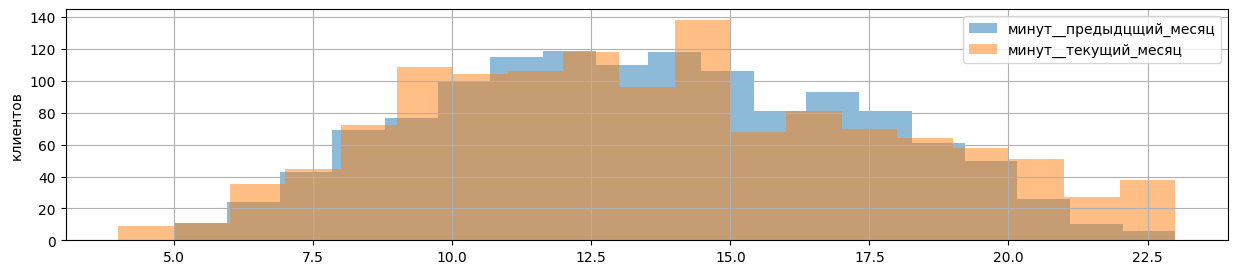

In [61]:
names = descr_all[descr_all['file']=='market_time']['cols_original'].to_list()
plt.rcParams['figure.figsize'] = (15, 3)
for i in m_time.columns:
    m_time[i].hist(bins=19, legend=True, alpha=0.5)
plt.legend(names)    
plt.ylabel('клиентов')
plt.show();

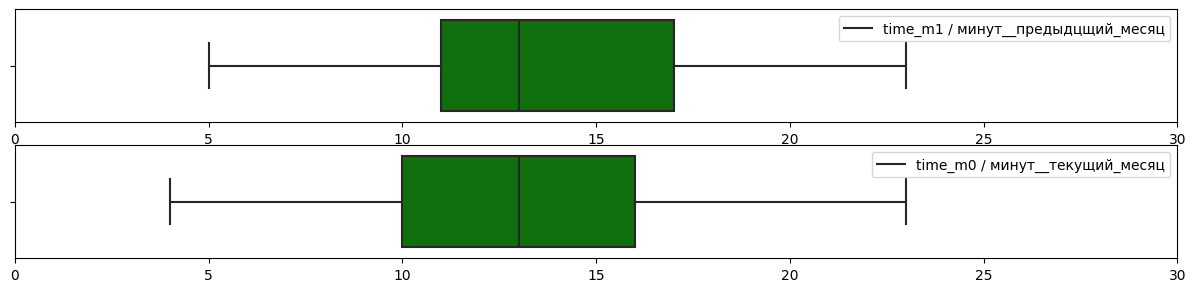

In [62]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.subplots(nrows=2, ncols=1)
names = descr_all[descr_all['file']=='market_time']['cols_original'].to_list()
_=0
for i in m_time.columns:   
    plt.subplot(3,1,_+1)
    ax=sns.boxplot(x=m_time[i], orient='h', color='green')
    ax.set_xlim(0, 30)
    plt.legend({f'{i} / {names[_]}'})
    plt.xlabel('')
    _+=1
plt.show;

Клиенты стали проводить на сайте незначительно меньше времени в текущем месяце по сравнению с предыдущим: Медианное и Максимальное время сохранилось, но чуть понизилось среднее время.

### Прибыль

count  mean   std   min  25%   50%   75%   max
av_profit_3m  1300.0   4.0  1.01  0.86  3.3  4.04  4.67  7.43

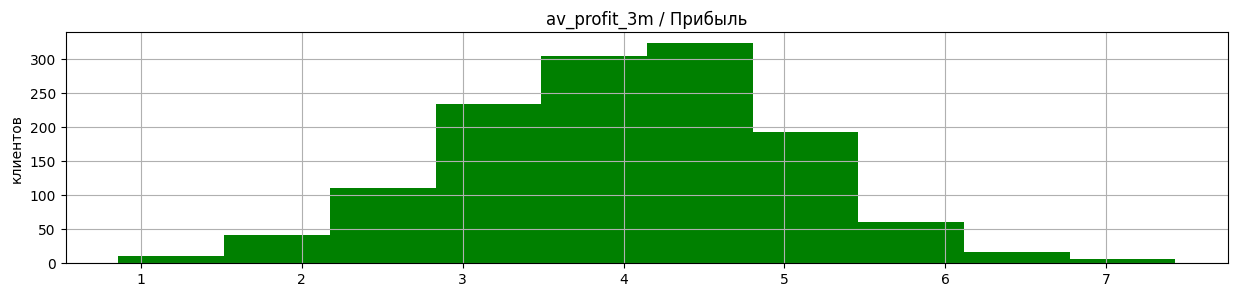

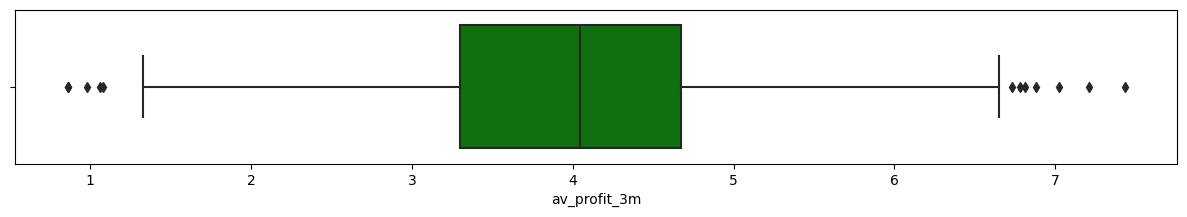

In [63]:
desc('av_profit_3m', df=money)

Значения прибыли от покупателей варьируются в диапазоне от 0.86 до 7.43. "Нулевых" или убыточных клиентов в данных не обнаружено. <br>
Значение прибыли также среднее за 3 месяца, без динамики.

### Отбор клиентов с покупательской активностью не менее трёх месяцев

Единственным полновременным (содержащим отдельные данные по каждому из 3 месяцев) источником данных является таблица о Выручке. Среди значений month-2 и month-1 встречаются нули, именно эти клиенты не попадут в отбор "постоянных":

In [64]:
display(df_all[(m_money['rev_m2']==0) | (m_money['rev_m1']==0)])

activity     level spam  av_connect_6m  n_connect_m0  n_days_reg  \
id                                                                          
215348  Снизилась   премиум   да            3.4             5         121   
215357  Снизилась  стандарт   да            3.9             5         154   
215359  Снизилась  стандарт   да            4.6             5         110   

        av_share_promo_6m                         top_cat  av_cat_look_m0  \
id                                                                          
215348                0.0                Товары для детей               6   
215357                0.0  Техника для красоты и здоровья               3   
215359                0.0               Домашний текстиль               4   

        n_basket_3m  n_crush  av_page_visit_3m  rev_m2  rev_m1  rev_m0  \
id                                                                       
215348            2        1                 5     0.0     0.0  3293.1   
215357            3        9                 5     0.0     0.0  5986.3   
215359            2        4                 2     0.0     0.0  4735.0   

        time_m1  time_m0  av_profit_3m  
id                                      
215348       13       14          0.98  
215357       12        6          4.66  
215359       13       11          5.08

Таким образом, только 3 клиента из 1300 представленных не попадают под критерий "покупательской активности не менее трёх месяцев".

### Выводы EDA

**Выводы** <br>
В ходе исследовательского анализа данных были рассмотрены показатели по следующим группам:

**Целевой показатель:** <br>
- рассчитанный класс **покупательской активности** распределён неравномерно: 62% / 38%, это придётся учесть при стратификации выборок для обучения

**Показатели Коммуникации:** <br>
- Тип сервиса (бинарный категориальный признак "стандарт / Премиум"), дисбаланс 71% / 29%;
- Разрешения на маркетинговые коммуникации (бинарный категориальный признак "да / нет"), дисбаланс 74% / 26%;
- Среднемесячное количество маркетинговых коммуникаций за 6 месяцев - варьируется от 2 до 7;
- Количество маркетинговых коммуникаций в текущем месяце - от 3 до 5;
- Длительность регистрации клиента: от 4 месяцев до 3 лет.

**Продуктовое поведение:** <br>
- Наиболее частая категория товаров за 6 месяцев - более равномерно распределённый категориальный НЕпорядковый признак, всего встречается 6 категорий;
- Среднее количество просматриваемых категорий за визит в текущем месяце - от 1 до 6;
- Среднее количество неоплаченных товаров в корзине за 3 месяца - от 0 до 10, среднее значение = 3;
- Среднемесячная доля акционных покупок за 6 месяцев - у большинства клиентов выше нуля и у 70% не превышает 30%, но выделяются единичные выбросы, чья доля акционных покупок от 60% и доходит до 99%.

**Поведение на сайте:** <br>
- Среднее количество просмотренных товаров за визит за 3 месяца - от 1 до 20. Среднее и медиана на уровне 8 страниц;
- Число сбоев, которые коснулись покупателя за время посещения сайта: почти каждый пользователь столкнулся с ошибками при посещении сайта. Распределение количества ошибок нормальное, среднее и медианное количество равно 4;
- Сумма времени, проведённого покупателем на сайте в течении месяца - клиенты стали проводить на сайте незначительно меньше времени в текущем месяце по сравнению с предыдущим: Медианное и Максимальное время сохранились на уровне (13 и 23 мин.), но чуть понизилось среднее время (на 16 секунд):
    - Время на сайте за текущий месяц;
    - Время на сайте за предыдущий месяц.

**Финансовое поведение:** <br>
- Сумма выручки от покупателя за месяц - клиенты со временем приносят всё больше выручки каждый месяц: растут Среднее, Медианное и Максимальное значения. Также возрастает и разброс - увеличивается значение стандартного отклонения.:
    - Выручка за текущий месяц;
    - Выручка за предыдущий месяц;
    - Выручка за предпредыдущий месяц. <br>
- Среднемесячная прибыль от продаж покупателю за 3 месяца.

В данных по выручке была выявлена единичная аномалия по сумме за текущий месяц - при прочих значениях до 8 тыс. руб. у одного клиента сумма составила 107 тыс. руб. <br>
Кроме того, в качестве критерия отбора выявлены ещё три клиента, которые не совершали покупок в прошлом и позапрошлом месяцах. При том, что эти данные корректны, они не подходят для задачи прогнозирования снижения покупательской активности - их активность наоборот выросла. <br>
Этих клиентов стоит исключить из данных для моделирования.

## Шаг 4. Объединение таблиц

Таблицы `market_file`, `market_money` и `market_time` мы соединили на этапе Предобработки данных для проверки дубликатов:

In [65]:
display(df)

activity     level spam  av_connect_6m  n_connect_m0  \
id                                                                    
215348        Снизилась   премиум   да            3.4             5   
215349        Снизилась   премиум   да            4.4             4   
215350        Снизилась  стандарт  нет            4.9             3   
215351        Снизилась  стандарт   да            3.2             5   
215352        Снизилась  стандарт  нет            5.1             3   
...                 ...       ...  ...            ...           ...   
216643  Прежний уровень  стандарт   да            6.6             3   
216644  Прежний уровень  стандарт  нет            5.1             4   
216645  Прежний уровень  стандарт   да            4.1             3   
216646  Прежний уровень  стандарт   да            6.3             5   
216647  Прежний уровень   премиум   да            4.0             5   

        n_days_reg  av_share_promo_6m                         top_cat  \
id                                                                      
215348         121               0.00                Товары для детей   
215349         819               0.75                Товары для детей   
215350         539               0.14               Домашний текстиль   
215351         896               0.99                Товары для детей   
215352        1064               0.94                Товары для детей   
...            ...                ...                             ...   
216643         318               0.24  Техника для красоты и здоровья   
216644         454               0.21               Домашний текстиль   
216645         586               0.20               Домашний текстиль   
216646         645               0.12  Техника для красоты и здоровья   
216647         906               0.94  Техника для красоты и здоровья   

        av_cat_look_m0  n_basket_3m  n_crush  av_page_visit_3m  rev_m2  \
id                                                                       
215348               6            2        1                 5     0.0   
215349               4            4        2                 5  4472.0   
215350               5            2        1                 5  4826.0   
215351               5            0        6                 4  4793.0   
215352               3            2        3                 2  4594.0   
...                ...          ...      ...               ...     ...   
216643               5            3        3                11  4704.0   
216644               6            2        3                 9  5299.0   
216645               3            2        5                 7  5334.0   
216646               3            3        5                 7  4725.0   
216647               4            5        3                12  5183.0   

        rev_m1  rev_m0  time_m1  time_m0  
id                                        
215348     0.0  3293.1       13       14  
215349  5216.0  4971.6       12       10  
215350  5457.5  5058.4        8       13  
215351  6158.0  6610.4       11       13  
215352  5807.5  5872.5        8       11  
...        ...     ...      ...      ...  
216643  3664.0  4741.7       14        7  
216644  4729.0  5353.0       12       11  
216645  5160.0  5139.2       12       18  
216646  4923.0  5224.6       18        7  
216647  4720.0  4448.3       15       10  

[1300 rows x 17 columns]

Сейчас остаётся только устранить:
- аномалию по Выручке в текущем месяце;
- 3 строки с нулевой выручкой в прошлых периодах;
- 11 полных дубликатов.

In [66]:
display(df.shape)

for c in ['rev_m0', 'rev_m1', 'rev_m2']:
    df = df[df[c] > 0]
    df = df[df[c] < limit]

df = df.drop_duplicates()

display(df.shape)

(1300, 17)

(1285, 17)

## Шаг 5. Корреляционный анализ

In [67]:
numeric = descr_all[((descr_all['dtype']=='float64') |
                     (descr_all['dtype']=='int64')) &
                     (descr_all['file'] !='money')]['cols_new'].to_list()
display(len(numeric))

13

Для числовых признаков проверим, распределены ли данные нормально.

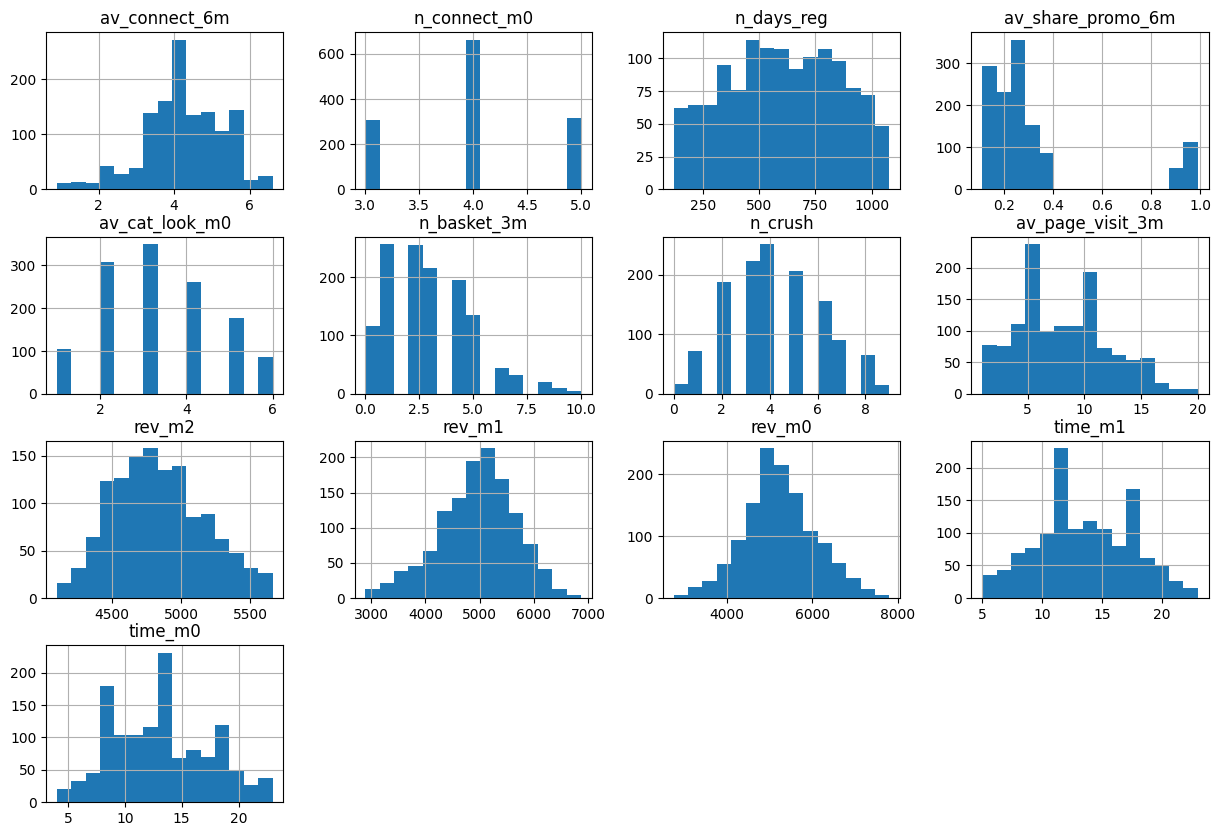

In [68]:
plt.rcParams['figure.figsize'] = (15, 10)
df.hist(bins=15);

Визуально распределение некоторых признаков не похоже на нормальное. <br>
Проверим гипотезу о нормальном распределении величин при помощи теста Шапиро-Уилка, уровень значимости определим равным 5%.

numeric  p_value_shapiro_test  p_value_shapiro_round
0       av_connect_6m          5.118807e-13               0.000000
1        n_connect_m0          1.102146e-36               0.000000
2          n_days_reg          6.275250e-15               0.000000
3   av_share_promo_6m          7.006492e-45               0.000000
4      av_cat_look_m0          6.721645e-24               0.000000
5         n_basket_3m          1.615221e-23               0.000000
6             n_crush          8.698219e-17               0.000000
7    av_page_visit_3m          1.805189e-14               0.000000
8              rev_m2          1.245047e-09               0.000000
9              rev_m1          2.780771e-07               0.000000
10             rev_m0          1.875379e-04               0.000188
11            time_m1          2.906022e-11               0.000000
12            time_m0          2.188010e-12               0.000000

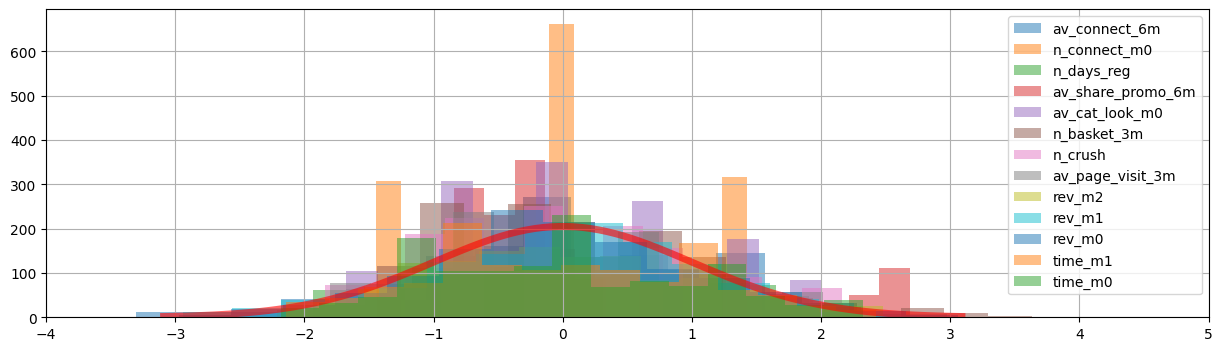

In [69]:
plt.rcParams['figure.figsize'] = (15, 4)
plt.xlim(-4,5)
plt.legend(numeric)
cols=[]
p_sh=[]
for c in numeric:
    normal = (df[c] - df[c].mean() ) / df[c].std()
    normal.hist(bins=15, alpha=0.5)
    cols.append(c)
    p_sh.append(shapiro(df[c])[1])
plt.legend(numeric);
sh_table = pd.DataFrame({'numeric':cols,'p_value_shapiro_test':p_sh})
sh_table['p_value_shapiro_round'] = sh_table['p_value_shapiro_test'].round(6)
display(sh_table)
x = np.linspace(norm.ppf(0.001),norm.ppf(0.999), 100)
val = len(df)/2.5
plt.plot(x, val*norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf');

p-значения тестов  Шапиро-Уилка для всех количественных переменных много меньше 5%, что позволяет отклонить гипотезу о нормальном распределении переменных.
Соответственно, для матрицы корреляции будем использовать коэффициент ранговой корреляции Спирмена.

In [70]:
def warmth(data = df, figsize=(13,5), fmt='.3f'):
    corr_matr = data.corr(method='spearman').abs()
    corr_matr['sum'] = corr_matr.sum()
    seq=corr_matr['sum'].sort_values(ascending=False).index
    corr_matr = data[seq].corr(method='spearman').round(3).abs()
    plt.rcParams['figure.figsize'] = figsize
    sns.heatmap(corr_matr, annot=True, fmt=fmt)
    plt.show();

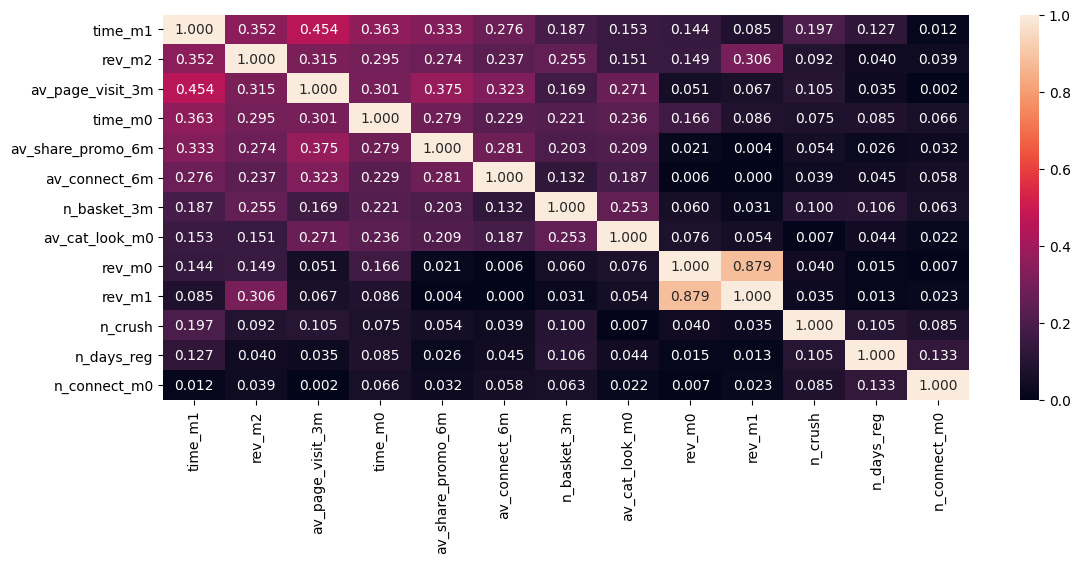

In [71]:
warmth(df)

Матрица корреляции для количественных переменных указывает на единственную высокую связь:
- Выручка в текущем месяце на 87,9% определяется значением Выручки в прошлом месяце.
Далее следуют только умеренные связи:
- Среднее количество страниц за визит связанно с временем на сайте в прошлом месяце;
- Среднее количество страниц за визит связанно с долей акционных покупок;
- Время на сайте в текущем месяце свзано с временем на сайте в прошлом месяце;
- Выручка в позапрошлом месяце связана с временем на сайте в прошлом месяце;
- Доля акционных покупок связана с временем на сайте в прошлом месяце. 

Единственная значимая мультиколлинеарность может возникнуть только при совместном использовании в модели показателей времени (предыдущего месяца и текущего). <br>
Стоит рассмотреть возможность ввода нового показателя - изменение / дельта времени между меяцами. <br>
Аналогичные показатели можно попробовать применить и к другому динамическому показателю - к Выручке. 

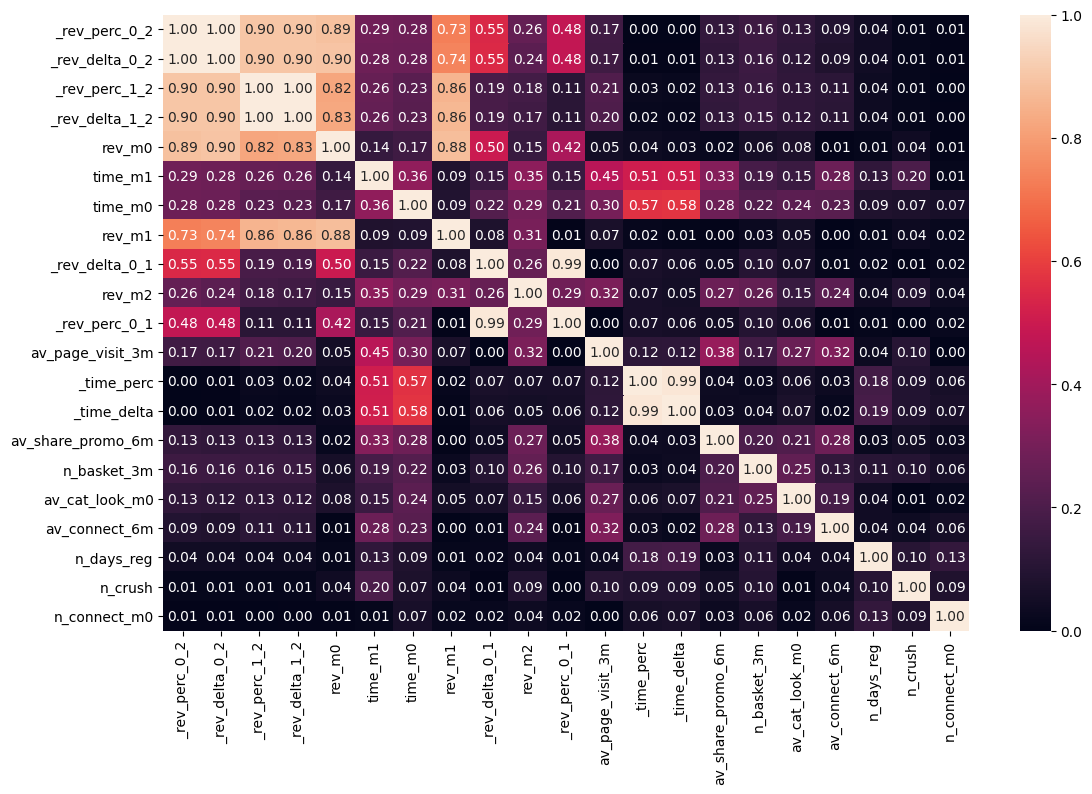

In [72]:
df_plus = df.copy()
df_plus['_time_delta'] =  df_plus['time_m0'] - df_plus['time_m1']
df_plus['_rev_delta_0_1'] = df_plus['rev_m0'] - df_plus['rev_m1']
df_plus['_rev_delta_0_2'] = df_plus['rev_m0'] - df_plus['rev_m2']
df_plus['_rev_delta_1_2'] = df_plus['rev_m1'] - df_plus['rev_m2']
df_plus['_time_perc'] = round(df_plus['_time_delta'] / df_plus['time_m1'],3)
df_plus['_rev_perc_0_1'] = round(df_plus['_rev_delta_0_1'] / df_plus['rev_m1'],3)
df_plus['_rev_perc_0_2'] = round(df_plus['_rev_delta_0_2'] / df_plus['rev_m2'],3)
df_plus['_rev_perc_1_2'] = round(df_plus['_rev_delta_1_2'] / df_plus['rev_m2'],3)
warmth(df_plus, fmt='.2f', figsize=(13,8))

Кроме корреляции выручки (текущего и прошлого месяца) почти все производные показатели также показывают мультиколлинеарность. <br>
Выделим все показатели с высокой корреляцией (более 90% по модулю), чтобы не забыть рассмотреть их исключение из модели.

In [73]:
def listing(data, limit=0.90):
    corr_matr = data.corr(method='spearman').round(3).abs()
    corr_list = corr_matr[(corr_matr>limit) & (corr_matr<1)
                         ].count().sort_values(ascending=False)
    corr_list = corr_list[corr_list>0]
    res = corr_matr.loc[corr_list.index, corr_list.index]
    return res
listing(df_plus)

_rev_perc_0_2  _rev_delta_1_2  _rev_perc_1_2  _rev_delta_0_2  \
_rev_perc_0_2           1.000           0.901          0.901           0.999   
_rev_delta_1_2          0.901           1.000          0.999           0.902   
_rev_perc_1_2           0.901           0.999          1.000           0.900   
_rev_delta_0_2          0.999           0.902          0.900           1.000   
_rev_perc_0_1           0.479           0.112          0.110           0.480   
_time_perc              0.002           0.021          0.025           0.005   
_rev_delta_0_1          0.545           0.191          0.189           0.548   
_time_delta             0.003           0.018          0.021           0.006   

                _rev_perc_0_1  _time_perc  _rev_delta_0_1  _time_delta  
_rev_perc_0_2           0.479       0.002           0.545        0.003  
_rev_delta_1_2          0.112       0.021           0.191        0.018  
_rev_perc_1_2           0.110       0.025           0.189        0.021  
_rev_delta_0_2          0.480       0.005           0.548        0.006  
_rev_perc_0_1           1.000       0.066           0.992        0.058  
_time_perc              0.066       1.000           0.068        0.987  
_rev_delta_0_1          0.992       0.068           1.000        0.058  
_time_delta             0.058       0.987           0.058        1.000

Для проверки наличия корреляции с категориальными признаками, кодируем их:

In [74]:
df_ohe = df.select_dtypes(exclude='number')
col_names = df_ohe.columns.to_list()
last = col_names[-1]
try:
    ohe = OneHotEncoder(drop='first', sparse=False) #old_version
except:
    ohe = OneHotEncoder(drop='first', sparse_output=False) #new_version
display(ohe)

df_ohe = ohe.fit_transform(df_ohe)
try:
    encoder_col_names = ohe.get_feature_names() #old_version
except:
    encoder_col_names = ohe.get_feature_names_out() #new_version

n_cols = df_ohe.shape[1]
i = 0
while i <4:
    col_names[i] = f'{col_names[i]}_'
    col_names.append(f'{last}_{i}')
    i+=1
df_ohe = pd.DataFrame(df_ohe, columns=col_names)
display(encoder_col_names)
display(df_ohe.tail(2))

OneHotEncoder(drop='first', sparse=False)

array(['x0_Снизилась', 'x1_стандарт', 'x2_нет',
       'x3_Косметика и аксесуары', 'x3_Кухонная посуда',
       'x3_Мелкая бытовая техника и электроника',
       'x3_Техника для красоты и здоровья', 'x3_Товары для детей'],
      dtype=object)

activity_  level_  spam_  top_cat_  top_cat_0  top_cat_1  top_cat_2  \
1283        0.0     1.0    0.0       0.0        0.0        0.0        1.0   
1284        0.0     0.0    0.0       0.0        0.0        0.0        1.0   

      top_cat_3  
1283        0.0  
1284        0.0

Взглянем на матрицу корреляции с кодированными категориальными переменными и выделим показатели с высокой корреляцией:

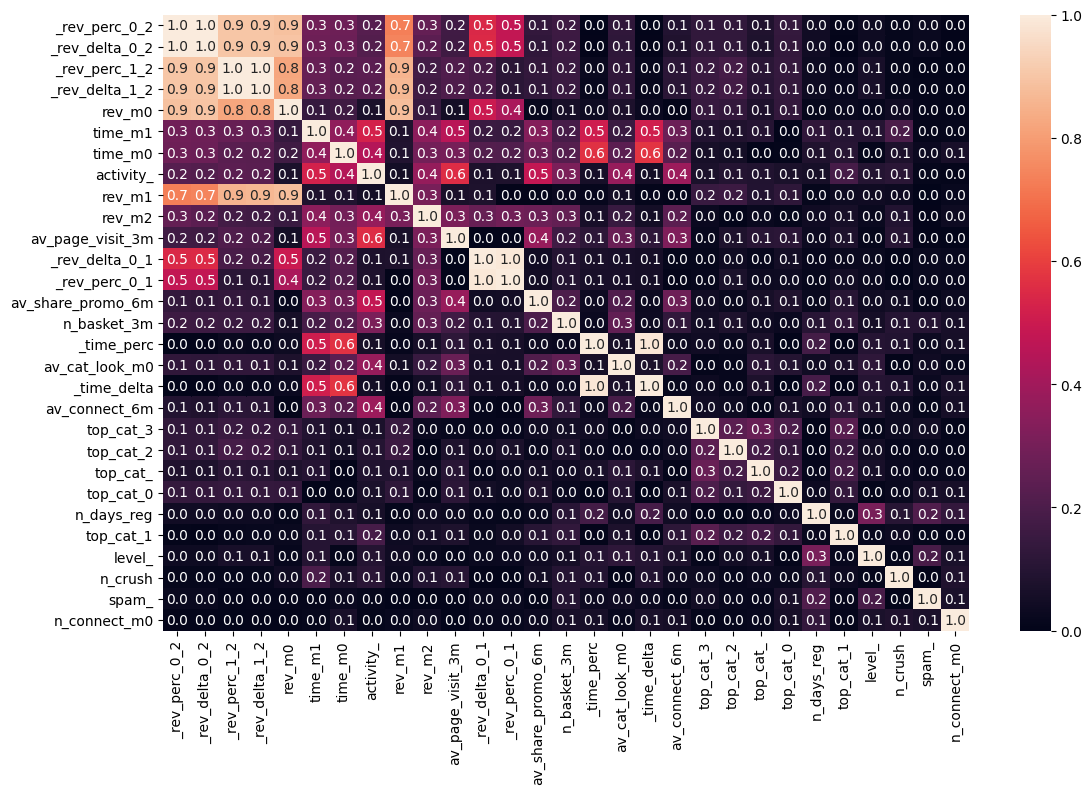

_rev_perc_0_2  _rev_delta_1_2  _rev_delta_0_2  _rev_perc_1_2  \
_rev_perc_0_2            1.0           0.901           0.999          0.901   

               _rev_delta_0_1  _rev_perc_0_1  _time_perc  _time_delta  
_rev_perc_0_2           0.545          0.479       0.002        0.003

In [75]:
df_plus_plus = pd.concat([df_plus.reset_index(drop=True), df_ohe], axis=1)
df_plus_plus.index = df_plus.index
warmth(df_plus_plus, figsize=(13,8), fmt='.1f')

display(listing(df_plus_plus).head(1))

Набор признаков с высокой корреляцией не изменился с добавлением категориальных переменных, <br>
в том числе не наблюдается утечки целевого признака "Покупательская активность". <br>
Обратим внимание на топ-10 показателей с самой высокой корреляцией с Активностью:

In [76]:
top = df_plus_plus.corr(method='spearman'
                 ).round(3).abs()['activity_'].sort_values(
    ascending=False)[1:11].to_frame().reset_index()
top.columns = ['cols_new', 'activity_corr']
top = top.merge(descr_all[['cols_new','cols_original', 'txt']], 
                on='cols_new', how='left')
top

cols_new  activity_corr                        cols_original  \
0   av_page_visit_3m          0.557                     Страниц_за_визит   
1            time_m1          0.527              минут__предыдцщий_месяц   
2  av_share_promo_6m          0.477                    Акционные_покупки   
3            time_m0          0.445                 минут__текущий_месяц   
4      av_connect_6m          0.390                   Маркет_актив_6_мес   
5     av_cat_look_m0          0.378  Средний_просмотр_категорий_за_визит   
6             rev_m2          0.374         Выручка__препредыдущий_месяц   
7        n_basket_3m          0.316   Неоплаченные_продукты_штук_квартал   
8      _rev_perc_1_2          0.236                                  NaN   
9     _rev_delta_1_2          0.231                                  NaN   

                                                 txt  
0  среднее количество страниц за один визит на са...  
1               времени на сайте за предыдущий месяц  
2  среднемесячная доля покупок по акции от общего...  
3                  времени на сайте за текущий месяц  
4  среднемесячное значение маркетинговых коммуник...  
5  сколько в среднем категорий покупатель просмот...  
6              сумма выручки за предпредыдущий месяц  
7  общее число неоплаченных товаров в корзине за ...  
8                                                NaN  
9                                                NaN

Рассмотрим матрицы корреляций отдельно для каждого класса активности:

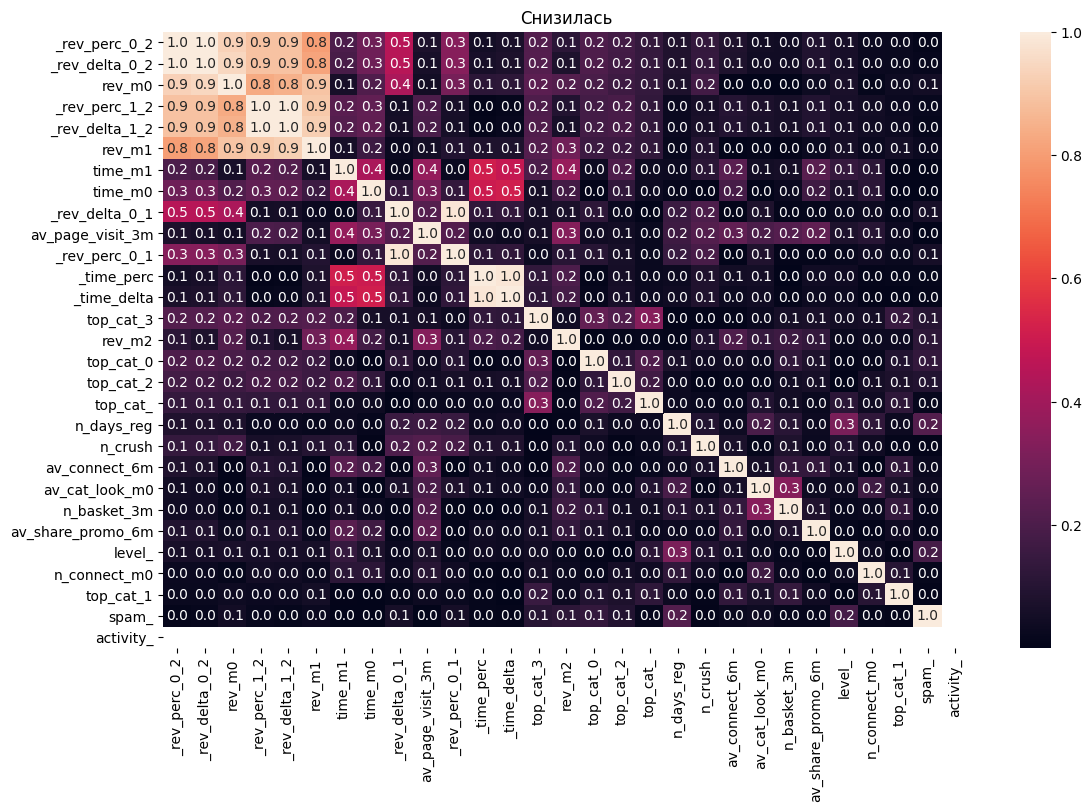

_rev_delta_1_2  rev_m1  _rev_delta_0_2  _rev_perc_0_2  \
_rev_delta_1_2             1.0   0.923           0.894          0.893   

                _rev_perc_1_2  rev_m0  _rev_perc_0_1  _time_delta  \
_rev_delta_1_2          0.998   0.848           0.06        0.023   

                _rev_delta_0_1  _time_perc  
_rev_delta_1_2           0.058       0.012

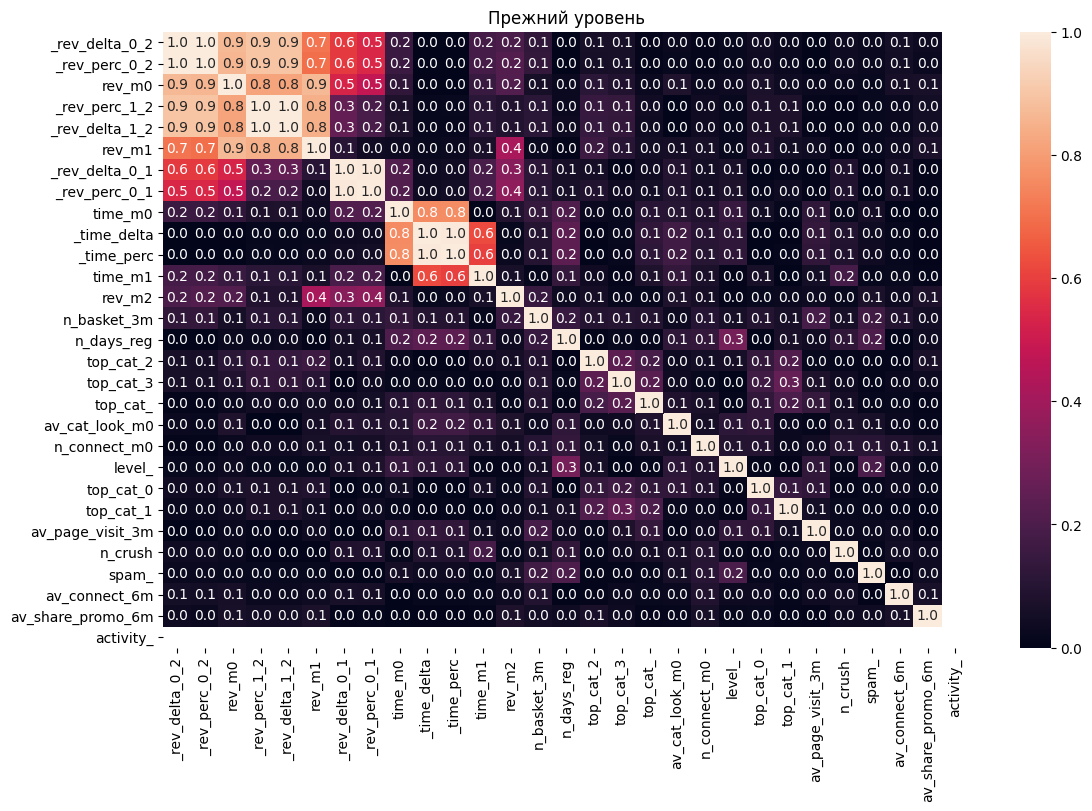

_rev_delta_0_1  _rev_delta_0_2  _rev_perc_1_2  _rev_perc_0_2  \
_rev_delta_0_1             1.0           0.589          0.254          0.589   

                _rev_perc_0_1  _time_perc  _time_delta  _rev_delta_1_2  
_rev_delta_0_1          0.994       0.046        0.035           0.254

In [77]:
for v in df['activity'].unique():
    plt.title(v)
    warmth(df_plus_plus[df_plus_plus['activity']==v], 
           figsize=(13,8), fmt='.1f')
    display(listing(df_plus_plus[df_plus_plus['activity']==v]).head(1))

Набор признаков с высокой корреляцией не изменился для отдельных классов целевого признака, <br>
но распределение взаимных корреляций у каждого класса различное.

Для моделирования исключим следующие синтезированные признаки абсолютного прироста, оставим только темпы прироста:

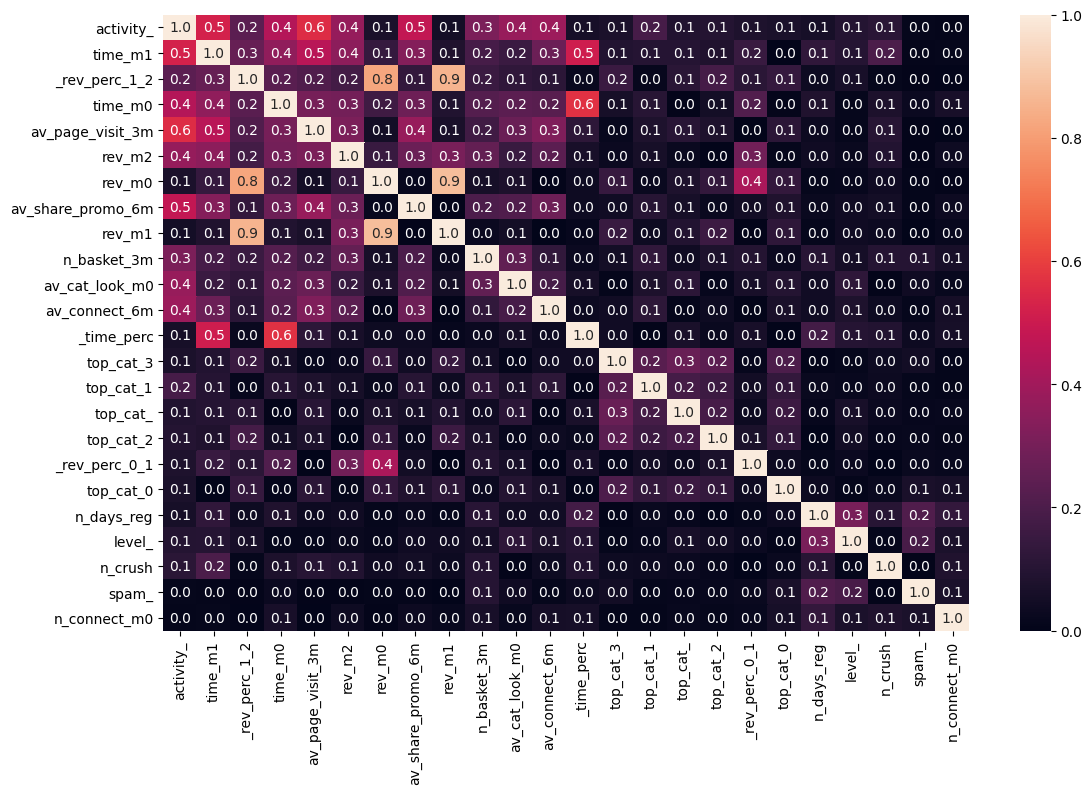

In [78]:
exclude = ['_rev_delta_1_2','_rev_delta_0_2','_rev_delta_0_1',
           '_rev_perc_0_2',
           '_time_delta']
warmth(df_plus_plus.drop(columns=exclude), 
           figsize=(13,8), fmt='.1f')

После удаления абсолютного прироста сильная мультиколлинеарность сохраняется только у показателей выручки. Так как мы сохраним процентные темпы прироста, мы можем без потери данных устранить и Выручку за прошлый / позапрошлый месяца.

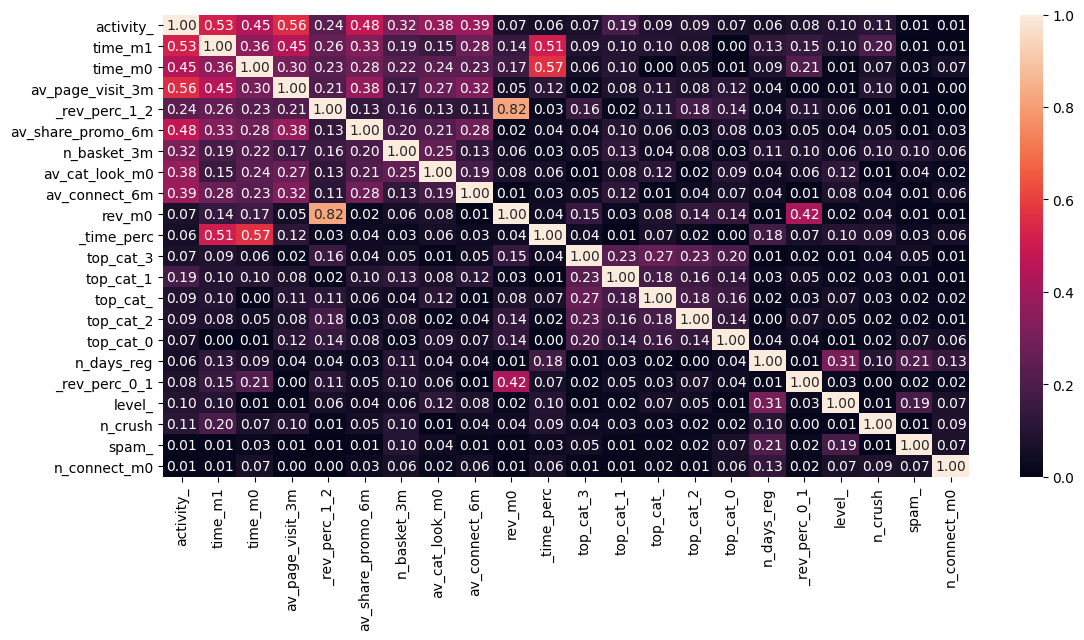

In [79]:
exclude = exclude + ['rev_m1', 'rev_m2']
warmth(df_plus_plus.drop(columns=exclude), 
           figsize=(13,6), fmt='.2f')

Рассмотрим матрицу корреляции с числовыми показателями, возведёнными в квадрат, для оценки целесообразности рассмотрения нелинейной степенной зависимости:

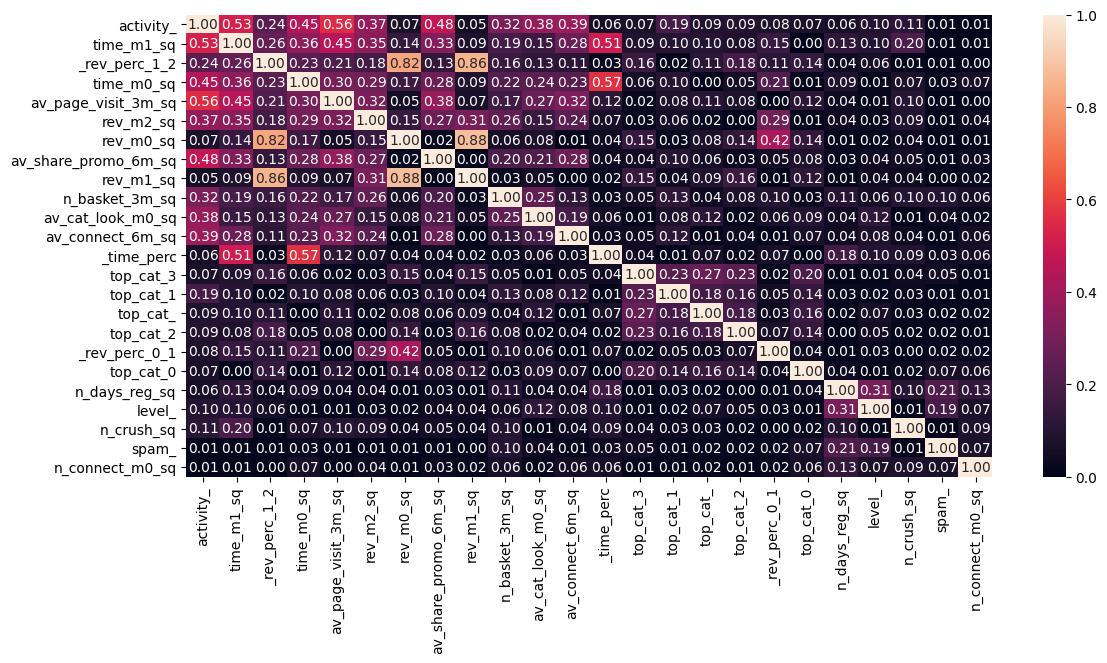

In [80]:
for c in numeric:
    new_c = f'{c}_sq'
    df_plus_plus[new_c] = df_plus_plus[c] * df_plus_plus[c]
warmth(df_plus_plus.drop(columns=exclude+numeric), 
           figsize=(13,6), fmt='.2f')

Существенного прироста корреляции, в том числе с целевым признаком не обнаружено, производные степенные показатели использовать в модели не будем.

При помощи диаграмм рассеяния рассмотрим распределение целевого признака по следующим парам параметров:
1. среднее количество **страниц** за один визит на сайт за 3 месяца / среднемесячная доля покупок **по акции** от общего числа покупок за 6 месяцев
2. **время** на сайте в текущем месяце / в предыдущем месяце
3. процент изменения **времени** текущего месяца к прошлому / процент изменения **выручки** текущего месяца к прошлому

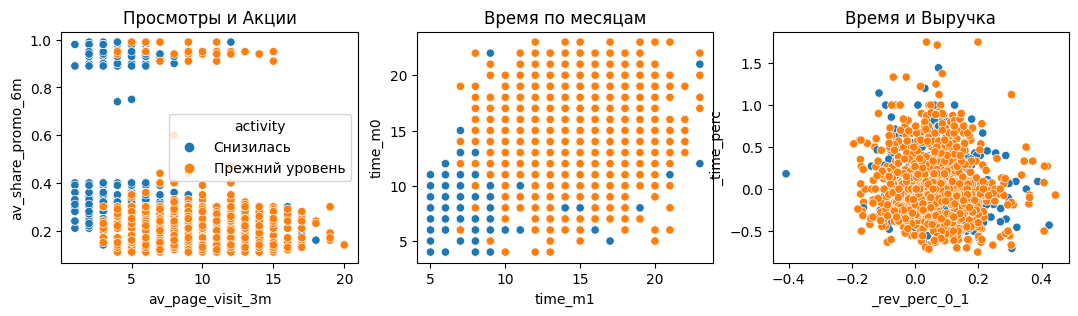

In [81]:
plt.rcParams['figure.figsize'] = (13, 3)
plt.subplots(nrows=1, ncols=3)
plt.subplot(131)
plt.title('Просмотры и Акции')
sns.scatterplot(data=df_plus_plus, hue='activity', 
                x='av_page_visit_3m', y='av_share_promo_6m');
plt.subplot(132)
plt.title('Время по месяцам')
sns.scatterplot(data=df_plus_plus, hue='activity', 
                x='time_m1', y='time_m0', legend=False);
plt.subplot(133)
plt.title('Время и Выручка')
sns.scatterplot(data=df_plus_plus, hue='activity', 
                x='_rev_perc_0_1', y='_time_perc', legend=False);

Визуально видна зависимость целевого показателя от количества просмотров и от времени на сайте. <br>
Странно, но не  видна зависимость с изменением времени и выручки.

**Выводы** <br>
На этапе корреляционного анализа рассчитаны показатели силы связи всех признаков с целевым и между собой.<br>
Выявлена достаточно сильная мультиколлинеарность между показателями выручки в текущем и предыдущем месяцах. Вместо абсолютного значения выручки прошлого и позапрошлого месяца для устранения мультиколлинеарности в модели предлагаю использовать показатели темпов прироста <br>
( `(m1-m2)/m2` ).<br>
Выделены Показатели, имеющие наиболее существенную связь с целевым.<br>
Рассмотрены матрицы корреляции отдельно для обоих классов целевого показателя, значимых для моделей отличий не выявлено.<br>
Проверена корреляция с возведёнными в квадрат числовыми переменными, по результату проверки существенного изменения силы связи не выявлено, степенную зависимость рассматривать нецелесообразно.<br>
Для показателей с наибольшим значением корреляции построены и рассмотрены диаграммы рассеяния: выделена сильная связь целевого признака со значениями времени на сайте и с количеством посещённых страниц. Однако, связи снижения активности со снижением выручки и времени не обнаружено.


## Шаг 6. Использование пайплайнов

По результатм корреляционного анализа, данные для моделирования дополним производными показателями для выручки и времени, а также уберём мультиколлинеарные показатели выручки прошлых месяцев.

In [82]:
adding_c = ['_time_perc', '_rev_perc_0_1', '_rev_perc_0_2', '_rev_perc_1_2']
df = df.drop(columns=['rev_m1', 'rev_m2']
            ).merge(df_plus_plus[adding_c], left_index=True, right_index=True)

Выделим признаки для моделирования и целевой признак отдельно: 

In [83]:
X = df.drop(columns='activity')
y = df.activity

Закодируем целевой признак при помощи `LabelEncoder`:

In [84]:
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)
display(pd.DataFrame({'y': y.sort_values().unique(), 
                      'activity': label_encoder.classes_}))

y         activity
0  0  Прежний уровень
1  1        Снизилась

Разделим признаки на 2 группы:
- категориальные
- числовые

In [85]:
ohe_columns = X.select_dtypes(include='object').columns.tolist()

num_columns = X.select_dtypes(include='number').columns.tolist()

display(
    len(ohe_columns + num_columns) - len(X.columns),
        ohe_columns, 
        num_columns)

0

['level', 'spam', 'top_cat']

['av_connect_6m',
 'n_connect_m0',
 'n_days_reg',
 'av_share_promo_6m',
 'av_cat_look_m0',
 'n_basket_3m',
 'n_crush',
 'av_page_visit_3m',
 'rev_m0',
 'time_m1',
 'time_m0',
 '_time_perc',
 '_rev_perc_0_1',
 '_rev_perc_0_2',
 '_rev_perc_1_2']

Разделяем выборки на тренировочную и тестовую:

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                random_state=RS, stratify=y)

Создадим пайпланы для трёх вариантов кодирования:
- Порядковый кодировщик заберёт категориальный небинарный признак и количественный категориальный
- Порядковый кодировщик заберёт только категориальный небинарный признак
- Без использования порядкового кодировщика, только `OneHotEncoder` и скейлеры для количественных

In [87]:
try:
    ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', 
                                               sparse=False))])
    #old_version
except:
    ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', 
                                               sparse_output=False))])
    #new_version
display(ohe)

OneHotEncoder(drop='first', sparse=False)

In [88]:
prepro3 = ColumnTransformer([
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],remainder='passthrough')

Создаём общий пайплайн:

In [89]:
pipe_final= Pipeline([('preprocessor', prepro3),
                      ('models', KNeighborsClassifier())])

Задаём ГиперПараметры для сравнения моделей: 

In [90]:
parametrs = [
    {
        'preprocessor': [prepro3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [KNeighborsClassifier()],
        'models__metric': ['euclidean', 'cityblock', 'minkowski']
    },
    {
        'preprocessor': [prepro3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [DecisionTreeClassifier(random_state=RS)],
        'models__max_depth': range(2, 11) 
    },
    {
        'preprocessor': [prepro3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [SVC(random_state=RS, degree=2, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'preprocessor': [prepro3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [LogisticRegression(random_state=RS, 
                                      solver='saga', max_iter=800)],
        'models__penalty': ['l1', 'l2']
    }
]

Инициализируем автоматизированный сплошной поиск ГиперПараметров и лучшей модели. <br>
В качестве метрики для оценки качества моделей выберем `roc-auc`, так как в целевом признаке присутствует значимый дисбалланс классов.

In [91]:
search = GridSearchCV(
    pipe_final, 
    param_grid=parametrs, 
    scoring='roc_auc',
    n_jobs=-1
)

Запускаем поиск

In [92]:
start = time.time()
search.fit(X_train, y_train);
loop_search_time = time.time() - start
display(f'Search time:{loop_search_time:.1f}')

'Search time:8.2'

Соберём результаты сравнения моделей в таблицу, для удобства консолидируем столбец гиперпараметров моделей:

In [93]:
result = pd.DataFrame(search.cv_results_)
param = ['param_models__metric', 
         'param_models__max_depth', 
         'param_models__kernel', 
         'param_models__penalty']

for c in param:
    result[c] = result[c].fillna('')

def merge_text(row):
    try:
        for c in param:
            if (row[c]=='') or (row[c]==np.nan): pass
            else: 
                row['param'] = f"{c.replace('param_models_','')} {row[c]}"
        return row
    except: return row
result = result.apply(merge_text, axis='columns')

_ = ['param_models', 'param_preprocessor__num']
_ = _+param
for c in _:
    result[c] = result[c].astype('string')

select = ['rank_test_score', 
          'mean_test_score', 
          'param_models', 
          'param_preprocessor__num',
          'param']
display(result[select].sort_values(by='rank_test_score').head(5))

rank_test_score  mean_test_score  \
28                1         0.911795   
2                 2         0.908402   
0                 3         0.906123   
4                 3         0.906123   
27                5         0.905300   

                                        param_models param_preprocessor__num  \
28  SVC(degree=2, probability=True, random_state=42)        StandardScaler()   
2                             KNeighborsClassifier()        StandardScaler()   
0                             KNeighborsClassifier()        StandardScaler()   
4                             KNeighborsClassifier()        StandardScaler()   
27  SVC(degree=2, probability=True, random_state=42)          MinMaxScaler()   

                param  
28        _kernel rbf  
2   _metric cityblock  
0   _metric euclidean  
4   _metric minkowski  
27       _kernel poly

Выведем параметры лучшей модели (и предобработки):

In [94]:
search.best_params_

{'models': SVC(degree=2, probability=True, random_state=42),
 'models__kernel': 'rbf',
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(drop='first',
                                                                 sparse=False))]),
                                  ['level', 'spam', 'top_cat']),
                                 ('num', StandardScaler(),
                                  ['av_connect_6m', 'n_connect_m0', 'n_days_reg',
                                   'av_share_promo_6m', 'av_cat_look_m0',
                                   'n_basket_3m', 'n_crush', 'av_page_visit_3m',
                                   'rev_m0', 'time_m1', 'time_m0', '_time_perc',
                                   '_rev_perc_0_1', '_rev_perc_0_2',
                                   '_rev_perc_1_2'])]),
 'preprocessor__num': Sta

Рассмотрим общие данные об оценках моделей без детализации по методу обработки категориальных фитчей:

In [95]:
display(pd.pivot_table(data=result, 
              values=['rank_test_score', 'mean_test_score'],
              index=['param_models', 'param','param_preprocessor__num'],
              aggfunc={'mean_test_score':['max','min','mean'], 
                       'rank_test_score':['count','mean']}
              ).round(3).sort_values(by=('mean_test_score','max'
                                        ), ascending=False))

mean_test_score  \
                                                                                                         max   
param_models                                       param             param_preprocessor__num                   
SVC(degree=2, probability=True, random_state=42)   _kernel rbf       StandardScaler()                  0.912   
KNeighborsClassifier()                             _metric cityblock StandardScaler()                  0.908   
                                                   _metric minkowski StandardScaler()                  0.906   
                                                   _metric euclidean StandardScaler()                  0.906   
SVC(degree=2, probability=True, random_state=42)   _kernel poly      MinMaxScaler()                    0.905   
LogisticRegression(max_iter=800, random_state=4... _penalty l2       MinMaxScaler()                    0.905   
SVC(degree=2, probability=True, random_state=42)   _kernel rbf       MinMaxScaler()                    0.904   
LogisticRegression(max_iter=800, random_state=4... _penalty l1       MinMaxScaler()                    0.904   
                                                                     StandardScaler()                  0.902   
SVC(degree=2, probability=True, random_state=42)   _kernel linear    MinMaxScaler()                    0.901   
LogisticRegression(max_iter=800, random_state=4... _penalty l2       StandardScaler()                  0.901   
SVC(degree=2, probability=True, random_state=42)   _kernel linear    StandardScaler()                  0.900   
                                                   _kernel poly      StandardScaler()                  0.893   
                                                   _kernel sigmoid   StandardScaler()                  0.884   
KNeighborsClassifier()                             _metric cityblock MinMaxScaler()                    0.879   
                                                   _metric euclidean MinMaxScaler()                    0.854   
                                                   _metric minkowski MinMaxScaler()                    0.854   
DecisionTreeClassifier(random_state=42)            _max_depth 3      MinMaxScaler()                    0.844   
                                                                     StandardScaler()                  0.844   
                                                   _max_depth 4      MinMaxScaler()                    0.828   
                                                                     StandardScaler()                  0.828   
                                                   _max_depth 6      MinMaxScaler()                    0.818   
                                                                     StandardScaler()                  0.818   
                                                   _max_depth 5      StandardScaler()                  0.816   
                                                                     MinMaxScaler()                    0.816   
                                                   _max_depth 8      StandardScaler()                  0.809   
                                                   _max_depth 7      MinMaxScaler()                    0.809   
                                                                     StandardScaler()                  0.809   
                                                   _max_depth 8      MinMaxScaler()                    0.809   
                                                   _max_depth 2      StandardScaler()                  0.799   
                                                                     MinMaxScaler()                    0.799   
                                                   _max_depth 9      MinMaxScaler()                    0.793   
                                                                     StandardScaler()                  0.793   
                                                   _max_depth

Лучшей моделью оказалась классификация Методом опорных векторов `SVC` с параметрами ядра kernel радиальной базисной функции `rbf`. С использованием Стандартизации переменных и без использования Порядкового кодировщика значение метрики `roc-auc` для этой модели составило 91.2% <br>
Сразу за первой строчкой следуют методы k-ближайших соседей также с применением Стандартизации переменных. <br>
Но почти все применённые модели показали результат выше 80%.

In [96]:
preds = search.best_estimator_.predict_proba(X_test)[0:,1]
score = roc_auc_score(y_test, preds)
display(f'Значение метрики roc-auc для лучшей модели равно {score:.3f}')

'Значение метрики roc-auc для лучшей модели равно 0.916'

Финальное тестирование на тестовой выборке лучшей модели (выбранной на кросс валидации):

In [97]:
display(result[select].sort_values(by='rank_test_score').head(1))

rank_test_score  mean_test_score  \
28                1         0.911795   

                                        param_models param_preprocessor__num  \
28  SVC(degree=2, probability=True, random_state=42)        StandardScaler()   

          param  
28  _kernel rbf

**Выводы** <br>
С использованием пайплайнов проведена сквозная (полная, сеточная) оценка 108 комбинаций:
- 4 модели классификации;
- от 2 до 10 вариантов ГиперПараметров для кажой модели;
- 3 варианта обработки категориальных признаков;
- 2 варианта масштабирования количественных переменных.
С учётом дисбаланса классов целевого признака в обучающих данных, в качестве метрики оценки была пременена `roc-auc`, как всеохватывающая метрика качества для моделей классификации. <br>
Результатом перебора оказалась модель классификациии метода опорных векторов `SVC` с ядром `rbf`, а также предобработка данных без использования порядкового кодировщика и с использованием стандартизации количественных переменных. Значение метрики лучшей модели = 91.2%

## Шаг 7. Анализ важности признаков

Для анализа важности признаков подготовим обучающие и тестовые данные с использованием предобработки из лучшей модели:

In [98]:
X_train_best = search.best_estimator_.named_steps['preprocessor'
                                                 ].fit_transform(X_train)
X_test_best = search.best_estimator_.named_steps['preprocessor'
                                                ].transform(X_test)

Взглянем на `preprocessor`: какие кодировщики использовались и к каким столбцам:

In [99]:
display(search.best_estimator_.named_steps['preprocessor'])

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['level', 'spam', 'top_cat']),
                                ('num', StandardScaler(),
                                 ['av_connect_6m', 'n_connect_m0', 'n_days_reg',
                                  'av_share_promo_6m', 'av_cat_look_m0',
                                  'n_basket_3m', 'n_crush', 'av_page_visit_3m',
                                  'rev_m0', 'time_m1', 'time_m0', '_time_perc',
                                  '_rev_perc_0_1', '_rev_perc_0_2',
                                  '_rev_perc_1_2'])])

Выведем имена признаков из `OneHotEncoder` и масштабированные столбцы:

In [100]:
try:
    ohe_cols = search.best_estimator_.named_steps['preprocessor']\
    .transformers_[0][1].named_steps['ohe'].get_feature_names() 
    #old_version
except:
    ohe_cols = search.best_estimator_.named_steps['preprocessor']\
    .transformers_[0][1].named_steps['ohe'].get_feature_names_out() 
    #new_version
    
scale_cols = search.best_estimator_.named_steps['preprocessor']\
.transformers_[1][2]

feature_names = list(ohe_cols) + list(scale_cols)
display(len(feature_names))

22

Приведём данные с признаками в формат ДатаФрейма для удобства:

In [101]:
X_train_best = pd.DataFrame(data=X_train_best, columns=feature_names)
X_train_best = X_train_best.set_index(X_train.index)
X_test_best = pd.DataFrame(data=X_test_best, columns=feature_names)
X_test_best = X_test_best.set_index(X_test.index)
display(X_train_best.head())
display(X_test_best.head())

x0_стандарт  x1_нет  x2_Косметика и аксесуары  x2_Кухонная посуда  \
id                                                                          
216504          1.0     0.0                       0.0                 0.0   
216467          1.0     0.0                       0.0                 0.0   
215646          1.0     1.0                       0.0                 0.0   
215968          1.0     0.0                       1.0                 0.0   
215560          1.0     0.0                       0.0                 0.0   

        x2_Мелкая бытовая техника и электроника  \
id                                                
216504                                      0.0   
216467                                      1.0   
215646                                      0.0   
215968                                      0.0   
215560                                      0.0   

        x2_Техника для красоты и здоровья  x2_Товары для детей  av_connect_6m  \
id                                                                              
216504                                0.0                  1.0      -0.950618   
216467                                0.0                  0.0      -0.161186   
215646                                0.0                  1.0      -1.345334   
215968                                0.0                  0.0       0.628246   
215560                                0.0                  1.0      -0.358544   

        n_connect_m0  n_days_reg  ...  n_basket_3m   n_crush  \
id                                ...                          
216504     -0.029127   -0.499637  ...    -0.427512  0.402855   
216467     -1.431616   -0.172370  ...    -1.415974 -0.111667   
215646     -1.431616    0.198799  ...    -1.415974 -0.626188   
215968      1.373361   -0.132459  ...     1.055181  0.402855   
215560     -0.029127   -0.072593  ...     1.549412 -0.111667   

        av_page_visit_3m    rev_m0   time_m1   time_m0  _time_perc  \
id                                                                   
216504          0.705633  0.051443  1.393517 -0.534722   -1.246028   
216467          0.201722 -0.420812  0.886640  0.914444   -0.097375   
215646         -1.058057 -0.519024 -1.394306 -1.017777    0.243674   
215968         -0.806102  0.924167 -0.127114  1.397499    1.163142   
215560         -1.310013 -2.568039  0.126324 -0.293194   -0.487535   

        _rev_perc_0_1  _rev_perc_0_2  _rev_perc_1_2  
id                                                   
216504      -0.053302      -0.357148      -0.400243  
216467      -0.797791      -0.865917      -0.548977  
215646      -0.817644      -0.275088       0.251354  
215968       0.641554       0.999570       0.732970  
215560      -0.758085      -2.523519      -2.758741  

[5 rows x 22 columns]

x0_стандарт  x1_нет  x2_Косметика и аксесуары  x2_Кухонная посуда  \
id                                                                          
216600          0.0     0.0                       0.0                 0.0   
216243          1.0     0.0                       1.0                 0.0   
215737          1.0     0.0                       1.0                 0.0   
216595          1.0     0.0                       1.0                 0.0   
216259          0.0     0.0                       0.0                 0.0   

        x2_Мелкая бытовая техника и электроника  \
id                                                
216600                                      0.0   
216243                                      0.0   
215737                                      0.0   
216595                                      0.0   
216259                                      0.0   

        x2_Техника для красоты и здоровья  x2_Товары для детей  av_connect_6m  \
id                                                                              
216600                                0.0                  0.0       0.134851   
216243                                0.0                  0.0      -0.950618   
215737                                0.0                  0.0      -3.318913   
216595                                0.0                  0.0      -0.062507   
216259                                0.0                  1.0       0.430888   

        n_connect_m0  n_days_reg  ...  n_basket_3m   n_crush  \
id                                ...                          
216600     -0.029127   -1.030449  ...     0.560950 -2.169751   
216243      1.373361    0.817414  ...    -0.921743  1.946418   
215737     -0.029127   -1.525341  ...     0.560950 -1.140709   
216595     -0.029127    0.581941  ...    -0.427512 -0.626188   
216259      1.373361   -1.824671  ...    -0.921743  0.402855   

        av_page_visit_3m    rev_m0   time_m1   time_m0  _time_perc  \
id                                                                   
216600         -0.050234 -0.869971  0.886640  0.914444   -0.097375   
216243         -0.806102 -1.881265 -0.380552  1.397499    1.493277   
215737         -1.310013  0.059776 -1.140868 -0.776249    0.205476   
216595          0.453677 -0.157721 -1.140868  0.914444    2.328165   
216259          2.973235 -0.171411  0.379763 -1.017777   -1.188732   

        _rev_perc_0_1  _rev_perc_0_2  _rev_perc_1_2  
id                                                   
216600      -1.085660      -0.608797       0.010547  
216243      -2.326475      -2.293753      -1.533455  
215737      -0.271686       0.244622       0.499245  
216595       0.125375       0.239151       0.201776  
216259       1.395970      -0.450149      -1.335143  

[5 rows x 22 columns]

Теперь обучим "Объяснятор" из модуля SHAP на лучшей модели. <br>
Так как у нас модель классификации методом опорных векторов, воспользуемся `KernelExplainer`:

In [102]:
model_best = search.best_estimator_.named_steps['models']
explainer = shap.KernelExplainer(model_best.predict_proba, X_train_best)

Using 963 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Обучающая выборка данных составляет 963 наблюдения, что превратит расчёт SHAP-значений для тестовых наблюдений в невероятно ресурсо- и время- ёмкий процесс.

Запишем названия пееременных в Объяснятор:

In [103]:
explainer.feature_names = feature_names

In [104]:
display(len(X_test_best))

322

Расчёт SHAP-значений для одного наблюдени занимает +/- 50 секунд. <br>
Так как количество наблюдений в тестовой выборке равно 322, расчёт SHAP для всех займёт 4.5 часа. <br>
Поэтому, рассчитаем SHAP всего на 5 наблюдениях, это займёт менее 5 минут:

In [105]:
shap_len = 5
shap_values = explainer(X_test_best[0:shap_len])
display(shap_values.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

(5, 22, 2)

Построим диаграмму общего вклада признаков в прогноз модели (не забывая что расчёт произведён не для полного объёма тестовой выборки):

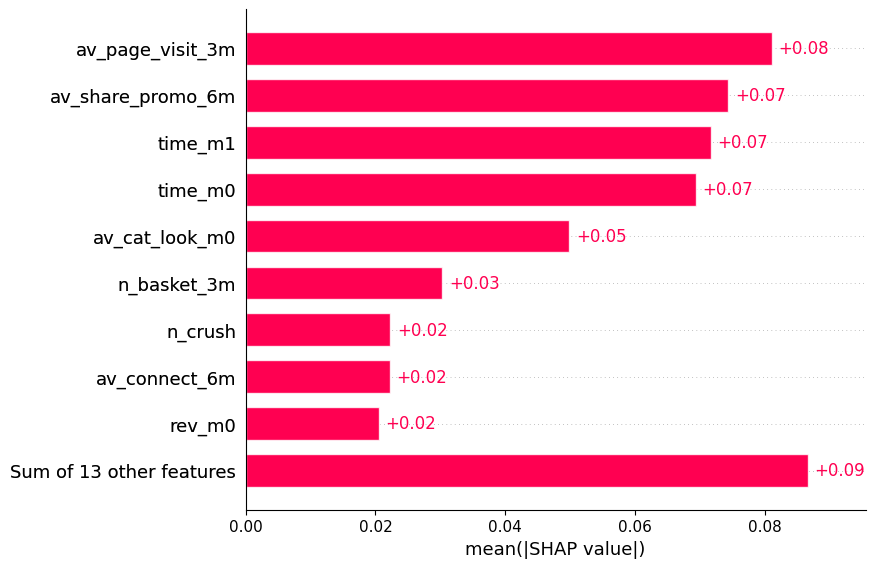

In [106]:
shap.plots.bar(shap_values[0:,0:,1])

Так сформировался перечень 9 наиболее влиятельных признаков модели. <br>
Запишем его в переменную:

In [107]:
seq = ['av_page_visit_3m', 'av_share_promo_6m', 'time_m1', 'time_m0', 
       'av_cat_look_m0', 'n_basket_3m', 'av_connect_6m', 'n_crush', 
       '_rev_perc_0_1', 'level', 'spam', 'top_cat']

Построим для себя табличку с наблюдениями тестовой выборки, обогащённые Прогнозом:

In [108]:
y_test_inv = pd.Series(label_encoder.inverse_transform(y_test), 
                        index=y_test.index, name='activ')

y_test.name = 'y_test'

proba_best = model_best.predict_proba(X_test_best)[0:,1]
proba_best = pd.Series(proba_best, name='proba_best', index=y_test.index)

y_pred_best = model_best.predict(X_test_best)
y_pred_best = pd.Series(y_pred_best, name='y_pred_best', index=y_test.index)

X_test_best_select = X.loc[X_test_best.index]
X_test_best_select = X_test_best_select[seq]

data_test_best = pd.concat([y_test_inv, y_test, proba_best, y_pred_best, 
                            X_test_best_select], 
                           axis=1)
display(data_test_best.head())

activ  y_test  proba_best  y_pred_best  av_page_visit_3m  \
id                                                                           
216600  Прежний уровень       0    0.133885            0                 8   
216243  Прежний уровень       0    0.127839            0                 5   
215737        Снизилась       1    0.981388            1                 3   
216595  Прежний уровень       0    0.398776            0                10   
216259  Прежний уровень       0    0.165445            0                20   

        av_share_promo_6m  time_m1  time_m0  av_cat_look_m0  n_basket_3m  \
id                                                                         
216600               0.40       17       17               5            4   
216243               0.11       12       19               4            1   
215737               0.36        9       10               2            4   
216595               0.94        9       17               6            2   
216259               0.14       15        9               3            1   

        av_connect_6m  n_crush  _rev_perc_0_1     level spam  \
id                                                             
216600            4.4        0         -0.050   премиум   да   
216243            3.3        8         -0.175  стандарт   да   
215737            0.9        2          0.032  стандарт   да   
216595            4.2        3          0.072  стандарт   да   
216259            4.7        5          0.200   премиум   да   

                      top_cat  
id                             
216600      Домашний текстиль  
216243  Косметика и аксесуары  
215737  Косметика и аксесуары  
216595  Косметика и аксесуары  
216259       Товары для детей

Рассмотрим наблюдение №2:

id                                  215737
activ                            Снизилась
y_test                                   1
proba_best                        0.981388
y_pred_best                              1
av_page_visit_3m                         3
av_share_promo_6m                     0.36
time_m1                                  9
time_m0                                 10
av_cat_look_m0                           2
n_basket_3m                              4
av_connect_6m                          0.9
n_crush                                  2
_rev_perc_0_1                        0.032
level                             стандарт
spam                                    да
top_cat              Косметика и аксесуары
Name: 2, dtype: object

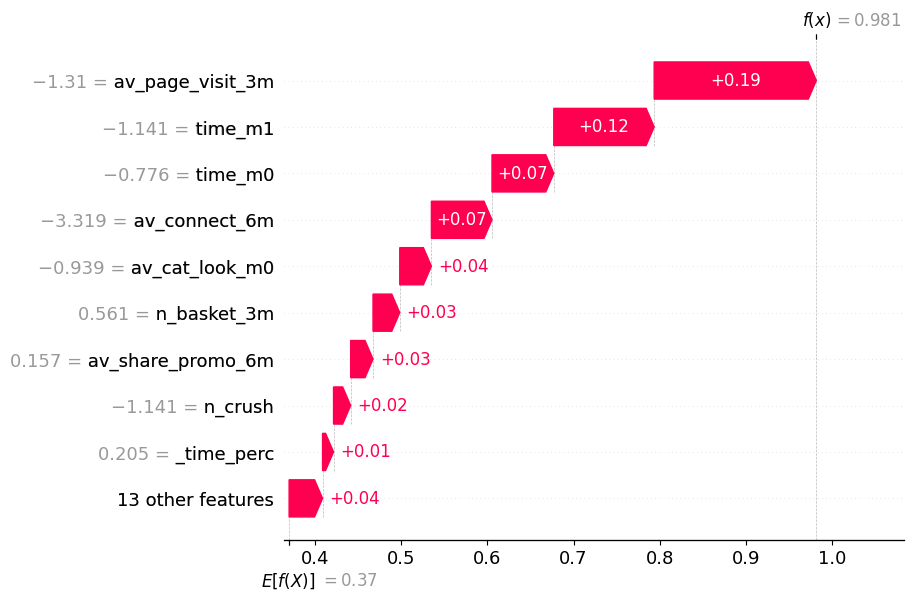

In [109]:
i=2
display(data_test_best.reset_index(drop=False).loc[i].T)
shap.plots.waterfall(shap_values[i,0:,1])

За счёт "среднего количества страниц за один визит" клиента, равного 3, модель правильно присвоила класс "Снизилась".

Для сравнения рассмотрим наблюдение № 4:

id                             216259
activ                 Прежний уровень
y_test                              0
proba_best                   0.165445
y_pred_best                         0
av_page_visit_3m                   20
av_share_promo_6m                0.14
time_m1                            15
time_m0                             9
av_cat_look_m0                      3
n_basket_3m                         1
av_connect_6m                     4.7
n_crush                             5
_rev_perc_0_1                     0.2
level                         премиум
spam                               да
top_cat              Товары для детей
Name: 4, dtype: object

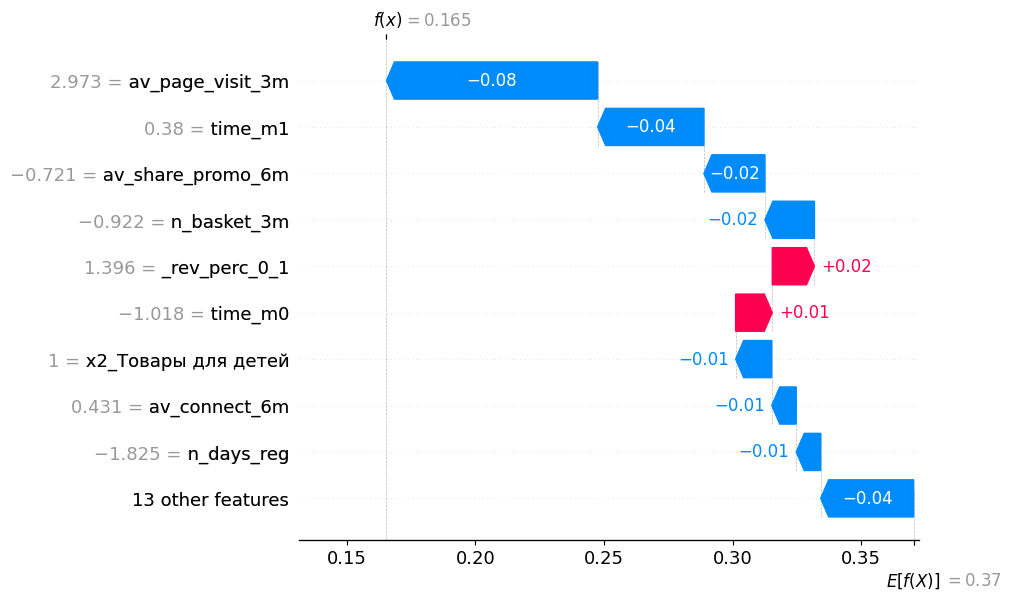

In [110]:
i=4
display(data_test_best.reset_index(drop=False).loc[i].T)
shap.plots.waterfall(shap_values[i,0:,1])

За счёт "среднего количества страниц за один визит", равного 20, модель правильно присвоила класс активности "Прежний уровень".

Выделим малозначимые для модели признаки:

In [111]:
top_c = seq[0:9]
minor = []

for c in list(X_train.columns):
    if c in top_c:
        pass
    else:
        minor.append(c)
minor.remove('rev_m0')

display(descr_all.query('cols_new == @minor'))

file      cols_new   dtype  nunique         cols_original  \
1  market_file         level  object        2           Тип сервиса   
2  market_file          spam  object        2    Разрешить сообщать   
4  market_file  n_connect_m0   int64        3  Маркет_актив_тек_мес   
5  market_file    n_days_reg   int64      658          Длительность   
7  market_file       top_cat  object        6  Популярная_категория   

                                                 txt  
1           уровень сервиса («премиум» / «стандарт»)  
2            можно ли присылать предложения о товаре  
4  количество маркетинговых коммуникаций в текуще...  
5                дней с момента регистрации на сайте  
7  самая популярная категория товаров у покупател...

Выделим наиболее значимые для модели признаки:

In [112]:
top_c.append('rev_m0')
top_c.append('rev_m1')
display(descr_all.query('cols_new == @top_c'))

file           cols_new    dtype  nunique  \
3    market_file      av_connect_6m  float64       41   
6    market_file  av_share_promo_6m  float64       42   
8    market_file     av_cat_look_m0    int64        6   
9    market_file        n_basket_3m    int64       11   
10   market_file            n_crush    int64       10   
11   market_file   av_page_visit_3m    int64       20   
13  market_money             rev_m1  float64     1122   
14  market_money             rev_m0  float64     1242   
15   market_time            time_m1    int64       19   
16   market_time            time_m0    int64       20   

                          cols_original  \
3                    Маркет_актив_6_мес   
6                     Акционные_покупки   
8   Средний_просмотр_категорий_за_визит   
9    Неоплаченные_продукты_штук_квартал   
10                       Ошибка_сервиса   
11                     Страниц_за_визит   
13            Выручка__предыдущий_месяц   
14               Выручка__текущий_месяц   
15              минут__предыдцщий_месяц   
16                 минут__текущий_месяц   

                                                  txt  
3   среднемесячное значение маркетинговых коммуник...  
6   среднемесячная доля покупок по акции от общего...  
8   сколько в среднем категорий покупатель просмот...  
9   общее число неоплаченных товаров в корзине за ...  
10  число сбоев, которые коснулись покупателя во в...  
11  среднее количество страниц за один визит на са...  
13                  сумма выручки за предыдущий месяц  
14                     сумма выручки за текущий месяц  
15               времени на сайте за предыдущий месяц  
16                  времени на сайте за текущий месяц

При моделировании и принятии бизнес решений стоит опираться на признаки, наиболее значимые для лучшей классификационной модели.

**Вывод:** <br>
Анализ признаков проведён для лучшей модели: метода опорных векторов, с ядром радиальной базисной функции. <br>
Категориальные признаки кодированы медодом OneHotEncoder, числовые - масштабированы Стандартизацией. <br>
Так как лучшей моделью оказалась не линейная Регрессия, то простой просмотр коэффициентов параметров невозможен. <br>
Для анализа важности признаков применён метод расчёта SHAP-значений. Так как расчёт shap-значений для каждого наблюдения тестовой выборки существенно длительный, анализ проводился всего на 5 наблюдениях. <br>
Анализ важности признаков в модели SVC позволил разделить входящие данные на наиболее и наименее значимые:
Решающие (наиболее значимые) признаки:
- **среднее количество страниц за один визит на сайт за 3 месяца**. Самый влиятельный признак для категоризации. Чем больше клиент выбирает товаров на сайте, тем менее вероятно снижение его активности.
- **среднемесячная доля покупок по акции от общего числа покупок за 6 месяцев**. Второй важный признак. Видимо, если клиент реагирует на акции, то его активность снижается с меньшей долей вероятности.
- **Время на сайте в текущем и предыдущем месяце**. Активность клиента в большой степени определяется времяпрепровождением на онлайн-площадке.

Из наименее влиятельных для модели признаков стоит выделить:
- Самая популярная для клиента категория купленных товаров,
- тип сервиса (ПРЕМИУМ / стандарт),
- длительность регистрации (как давно клиент зарегистрировался на сайте),
- наличие Согласия на спам,
- количество маркетинговых коммуникаций в текущем месяце.

Остальные признаки можно условно отнести к (средне) значимым.

## Шаг 8. Сегментация покупателей

### Подготовка данных для сегментации

Для сегментации покупателей используем результаты лучшей модели и данные о прибыльности.

In [113]:
y_train_pred = model_best.predict(X_train_best)
y_train_pred = pd.Series(y_train_pred, index=y_train.index)
predict = pd.concat([y_train_pred, y_pred_best], axis=0).sort_index()
predict.name = 'predict'

In [114]:
y_train_proba = model_best.predict_proba(X_train_best)[0:,1]
y_train_proba = pd.Series(y_train_proba, index=y_train.index)
predict_proba = pd.concat([y_train_proba, proba_best], axis=0).sort_index()
predict_proba.name = 'predict_proba'

In [115]:
train = y_train.to_frame()
train['split'] = 'train'
train = train['split']
test = y_test.to_frame()
test['split'] = 'test'
test = test['split']
split = pd.concat([train, test], axis=0).sort_index()

In [116]:
table = pd.concat([split, predict, predict_proba], axis=1)
table = table.join(money, how='left')
display(table)

split  predict  predict_proba  av_profit_3m
id                                                 
215349   test        1       0.966415          4.16
215350  train        1       0.643942          3.13
215351   test        1       0.883217          4.87
215352  train        1       0.948821          4.21
215353   test        1       0.906233          3.95
...       ...      ...            ...           ...
216643  train        0       0.122559          4.44
216644  train        0       0.088777          6.11
216645   test        0       0.064325          3.29
216646  train        0       0.085483          4.03
216647  train        0       0.340701          3.28

[1285 rows x 4 columns]

Создадим для удобства дополнительную категорию, равную квартилю прибыльности клиента:

In [117]:
borders = table.av_profit_3m.describe()[4:7]
display(borders)

25%    3.30
50%    4.04
75%    4.67
Name: av_profit_3m, dtype: float64

In [118]:
table['profit_gr'] = (np.where(table.av_profit_3m < borders[0], 0, 
                      np.where(table.av_profit_3m < borders[1], 1, 
                      np.where(table.av_profit_3m < borders[2], 2, 3))))
display(pd.pivot_table(data=table,
                       index=['profit_gr'],
                       columns=[],
                       values=['av_profit_3m'],
                       aggfunc={'av_profit_3m':['min', 'max', 'mean']}).round(2))

av_profit_3m            
                   max  mean   min
profit_gr                         
0                 3.29  2.69  0.86
1                 4.03  3.68  3.30
2                 4.66  4.34  4.04
3                 7.43  5.24  4.67

Дополним таблицу исходным значением покупательской активности, помесячной выручкой и временем на сайте:

In [119]:
table = table.join(m_money, how='left')
_ = ['activity',
     'time_m1',
     'time_m0']
table = table.join(df[_], how='left')

display(table)

split  predict  predict_proba  av_profit_3m  profit_gr  rev_m2  \
id                                                                       
215349   test        1       0.966415          4.16          2  4472.0   
215350  train        1       0.643942          3.13          0  4826.0   
215351   test        1       0.883217          4.87          3  4793.0   
215352  train        1       0.948821          4.21          2  4594.0   
215353   test        1       0.906233          3.95          1  5124.0   
...       ...      ...            ...           ...        ...     ...   
216643  train        0       0.122559          4.44          2  4704.0   
216644  train        0       0.088777          6.11          3  5299.0   
216645   test        0       0.064325          3.29          0  5334.0   
216646  train        0       0.085483          4.03          1  4725.0   
216647  train        0       0.340701          3.28          0  5183.0   

        rev_m1  rev_m0         activity  time_m1  time_m0  
id                                                         
215349  5216.0  4971.6        Снизилась       12       10  
215350  5457.5  5058.4        Снизилась        8       13  
215351  6158.0  6610.4        Снизилась       11       13  
215352  5807.5  5872.5        Снизилась        8       11  
215353  4738.5  5388.5        Снизилась       10       10  
...        ...     ...              ...      ...      ...  
216643  3664.0  4741.7  Прежний уровень       14        7  
216644  4729.0  5353.0  Прежний уровень       12       11  
216645  5160.0  5139.2  Прежний уровень       12       18  
216646  4923.0  5224.6  Прежний уровень       18        7  
216647  4720.0  4448.3  Прежний уровень       15       10  

[1285 rows x 11 columns]

Дополним таблицу вычесляемымы производными переменными от динамических показателей времени и выручки:

In [120]:
table['_rev_delta_0_1'] = table['rev_m0'] - table['rev_m1']
table['_rev_delta_0_2'] = table['rev_m0'] - table['rev_m2']
table['_rev_delta_1_2'] = table['rev_m1'] - table['rev_m2']

table['_time_delta'] =  table['time_m0'] - table['time_m1']
table['_time_perc'] = round(table['_time_delta'] / table['time_m1'],3)

table['_rev_perc_0_1'] = round(table['_rev_delta_0_1'] / table['rev_m1'],3)
table['_rev_perc_0_2'] = round(table['_rev_delta_0_2'] / table['rev_m2'],3)
table['_rev_perc_1_2'] = round(table['_rev_delta_1_2'] / table['rev_m2'],3)

Взглянем на диаграммы рассеяния абсолютного изменения Выручки между различными месяцами:

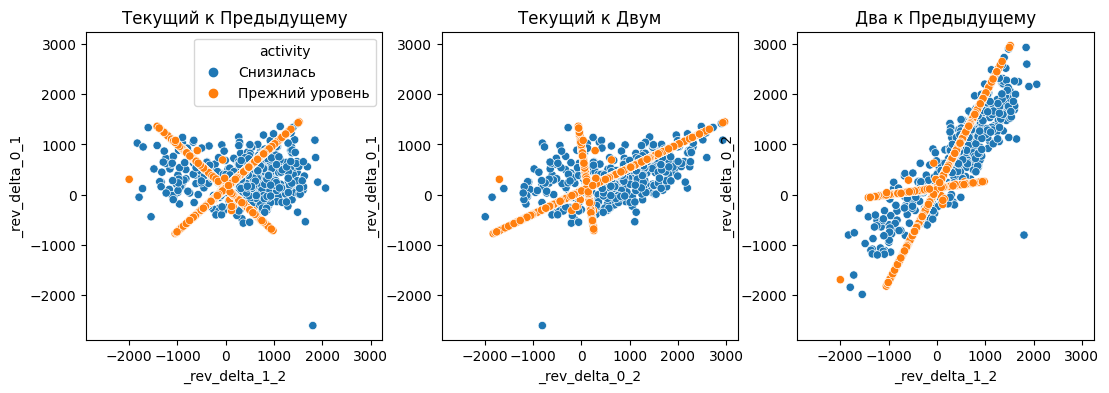

In [121]:
plt.rcParams['figure.figsize'] = (13, 4)
_min = min([min(table._rev_delta_0_1), 
            min(table._rev_delta_1_2), 
            min(table._rev_delta_0_2)])
_max = max([max(table._rev_delta_0_1), 
            max(table._rev_delta_1_2), 
            max(table._rev_delta_0_2)])
_border = (_max - _min) * 0.05
_range = (_min-_border, _max+_border)

plt.subplots(nrows=1, ncols=3)
plt.subplot(131)
plt.title('Текущий к Предыдущему')
plt.xlim(_range)
plt.ylim(_range)
sns.scatterplot(data=table, hue='activity', 
                x='_rev_delta_1_2', y='_rev_delta_0_1');
plt.subplot(132)
plt.title('Текущий к Двум')
plt.xlim(_range)
plt.ylim(_range)
sns.scatterplot(data=table, hue='activity', 
                x='_rev_delta_0_2', y='_rev_delta_0_1', legend=False);
plt.subplot(133)
plt.title('Два к Предыдущему')
plt.xlim(_range)
plt.ylim(_range)
sns.scatterplot(data=table, hue='activity', 
                x='_rev_delta_1_2', y='_rev_delta_0_2', legend=False);

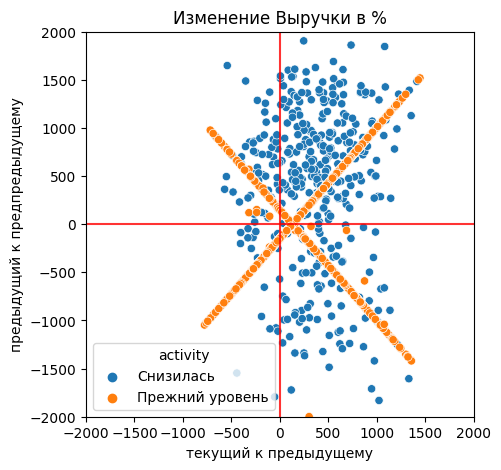

In [122]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.title('Изменение Выручки в %')
plt.xlim((-2000, 2000))
plt.ylim((-2000, 2000))
plt.axvline(0, 0, 1, color="red", alpha=0.8)
plt.axhline(0, 0, 1, color="red", alpha=0.8)
plt.ylabel('предыдущий к предпредыдущему')
plt.xlabel('текущий к предыдущему')
sns.scatterplot(data=table, hue='activity', 
                x='_rev_delta_0_1', y='_rev_delta_1_2');

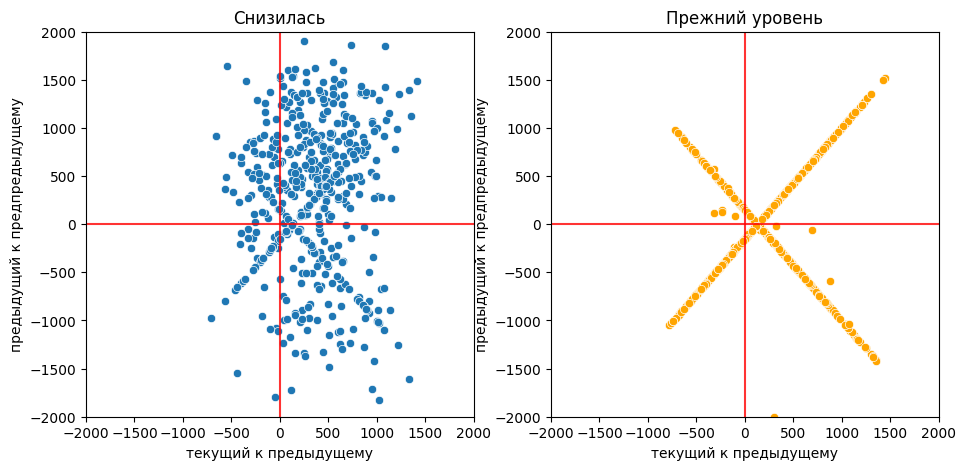

In [123]:
plt.rcParams['figure.figsize'] = (11,5)
plt.subplots(nrows=1, ncols=2)
plt.subplot(121)
plt.title('Снизилась')
plt.xlim((-2000, 2000))
plt.ylim((-2000, 2000))
plt.axvline(0, 0, 1, color="red", alpha=0.8)
plt.axhline(0, 0, 1, color="red", alpha=0.8)
plt.ylabel('предыдущий к предпредыдущему')
plt.xlabel('текущий к предыдущему')
sns.scatterplot(data=table[table.activity=='Снизилась'], 
                x='_rev_delta_0_1', y='_rev_delta_1_2');
plt.subplot(122)
plt.title('Прежний уровень')
plt.xlim((-2000, 2000))
plt.ylim((-2000, 2000))
plt.axvline(0, 0, 1, color="red", alpha=0.8)
plt.axhline(0, 0, 1, color="red", alpha=0.8)
plt.ylabel('предыдущий к предпредыдущему')
plt.xlabel('текущий к предыдущему')
sns.scatterplot(data=table[table.activity=='Прежний уровень'], color='orange',
                x='_rev_delta_0_1', y='_rev_delta_1_2');

Интересные выводы можно сделать из Графика абсолютного изменения Выручки "Текущего (m0 - m1) к Предыдущему (m1 - m2) месяцу":<br>

**Прежний уровень активности** в исходных данных проставляется для двух категорий клиентов ("оранжевый крестик"):
1. Динамика изменения Выручки которых стабильна: 
- Одинаковое снижение Выручки из предпредыдущего в предпредыдущий и из предыдущего в текущий;
- Одинаковый рост Выручки из предпредыдущего в предпредыдущий и из предыдущего в текущий.
2. Динамика изменения Выручки которых обратна (компенсирует изменение прошлого периода):
- Снижение Выручки из предпредыдущего в предпредыдущий и Рост Выручки на сопоставимое снижению из предыдущего в текущий;
- Рост Выручки из предпредыдущего в предпредыдущий и сопоставимое Снижение из предыдущего в текущий.

**Снижение активности** соответственно размечено в исходных данных для всех клиентов, чьё изменение выручки не попадает под выше описанные правила.  

### Сегментация покупателей

На основе динамических показателей выделим сегмент клиентов, чьи выручка и время на сайте снижаются. <br>
Для этого создадим категории изменения Времени и Выручки:

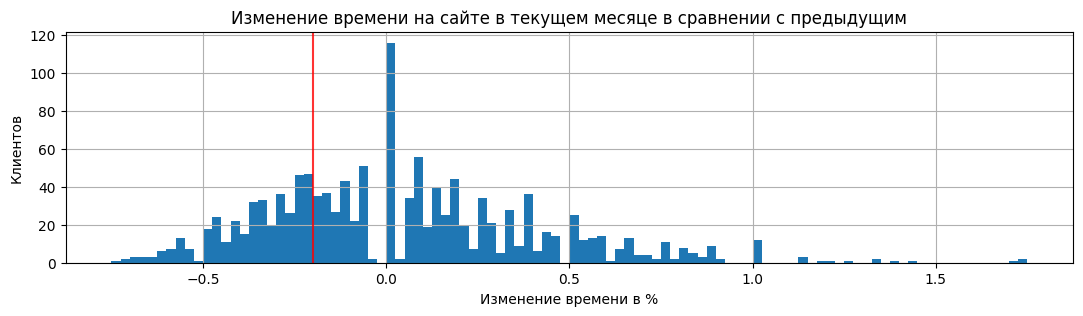

In [124]:
plt.rcParams['figure.figsize'] = (13, 3)
plt.title('Изменение времени на сайте в текущем месяце в сравнении с предыдущим')
plt.xlabel('Изменение времени в %')
plt.ylabel('Клиентов')
plt.axvline(-0.2, 0, 1, color="red", alpha=0.8)
table._time_perc.hist(bins=100);

Установим критерий отбора снижения времени на сайте в 20%:

In [125]:
edge_t = -0.20
table['time_gr'] = (np.where(table._time_perc <= edge_t, -1, 0))

display(pd.pivot_table(data=table,
                       index=['time_gr'],
                       columns=[],
                       values=['_time_perc'],
                       aggfunc={
                           '_time_perc':['min', 'max', 'mean', 'count']}
                      ).round(2))

_time_perc                  
             count   max  mean   min
time_gr                             
-1             376 -0.20 -0.36 -0.75
 0             909  1.75  0.20 -0.19

Выявлены 376 клиентов, чьё снижение времени на сайте в текущем месяце по сравнению с предыдущим составило не менее 20%. 

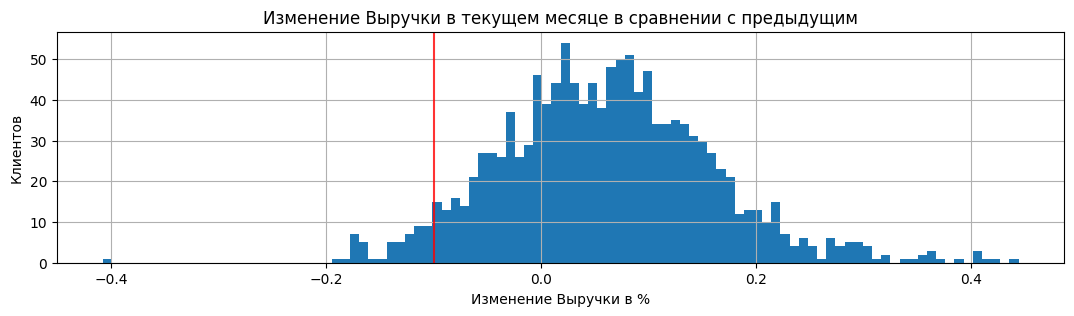

In [126]:
plt.rcParams['figure.figsize'] = (13, 3)
plt.title('Изменение Выручки в текущем месяце в сравнении с предыдущим')
plt.xlabel('Изменение Выручки в %')
plt.ylabel('Клиентов')
plt.axvline(-0.1, 0, 1, color="red", alpha=0.8)
table._rev_perc_0_1.hist(bins=100);

Установим критерий отбора снижения Выручки в 10%:

In [127]:
edge_r = -0.10
table['rev_gr_m01'] = (np.where(table._rev_perc_0_1 <= edge_r, -1, 0))

display(pd.pivot_table(data=table,
                       index=['rev_gr_m01'],
                       columns=[],
                       values=['_rev_perc_0_1'],
                       aggfunc={
                           '_rev_perc_0_1':['min', 'max', 'mean', 'count']}
                      ).round(2))

_rev_perc_0_1                  
                   count   max  mean   min
rev_gr_m01                                
-1                    55 -0.10 -0.14 -0.41
 0                  1230  0.44  0.07 -0.10

Выявлено 55 клиентов, чья выручка в текущем месяце на 10% или более ниже, чем в предыдущем.

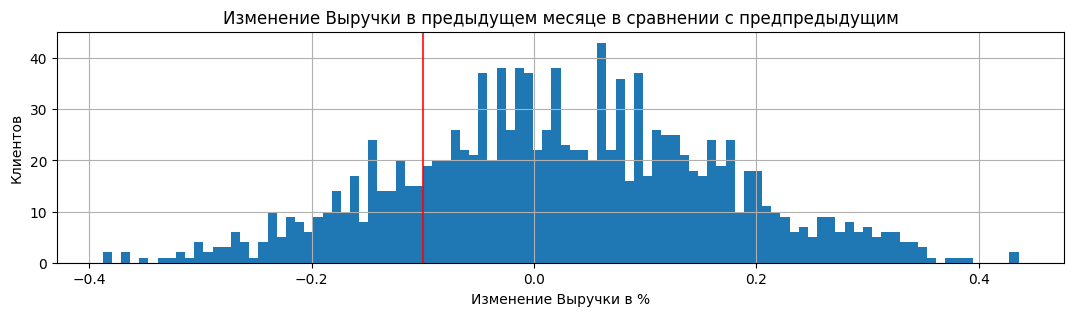

In [128]:
plt.rcParams['figure.figsize'] = (13, 3)
plt.title('Изменение Выручки в предыдущем месяце в сравнении с предпредыдущим')
plt.xlabel('Изменение Выручки в %')
plt.ylabel('Клиентов')
plt.axvline(edge_r, 0, 1, color="red", alpha=0.8)
table._rev_perc_1_2.hist(bins=100);

In [129]:
table['rev_gr_m12'] = (np.where(table._rev_perc_1_2 <= edge_r, -1, 0))

display(pd.pivot_table(data=table,
                       index=['rev_gr_m12'],
                       columns=[],
                       values=['_rev_perc_1_2'],
                       aggfunc={
                           '_rev_perc_1_2':['min', 'max', 'mean', 'count']}
                      ).round(2))

_rev_perc_1_2                  
                   count   max  mean   min
rev_gr_m12                                
-1                   245 -0.10 -0.18 -0.39
 0                  1040  0.44  0.07 -0.10

Выявлено 245 клиентов, чья выручка в предыдущем месце на 10% и более ниже, чем в предпредыдущем.

In [130]:
display(pd.pivot_table(data=table,
                       index=['rev_gr_m01', 'rev_gr_m12'],
                       columns=['time_gr'],
                       values=['split'],
                       aggfunc={'split': ['count']}))

split     
                      count     
time_gr                  -1    0
rev_gr_m01 rev_gr_m12           
-1         -1            12   30
            0             4    9
 0         -1            59  144
            0           301  726

Исходя из группировок по изменениям динамических признаков, можно выделить следующие сегменты:
- Клиенты с ростом или незначительным (до -10%) снижением Выручки два месяца подряд;
- Клиенты с противоположной динамикой выручки из месяца в месяц;
- Клиенты, чья выручка снижается два месяца подряд на 10% или более.

Каждый из этих сегментов можно также разбить на 2 группы по критерию снижения времени на сайте. *Однако,*

Снижение времени на сайте при сохранении стабильной Выручки может свидетельствовать не только о снижении покупательской активности. <br>
Например, клиент может тратить меньше времени на сайте потому что уже все товары изучил и делает регулярные закупки одних и тех же знакомых товаров,  <br>
просто быстрее ориентируется на сайте, не тратя как раньше много времени.  <br>
Или сайт не зависает и работает быстрее.  <br>
Поэжтому, несмотря на первично кажущуюся близость понятий "снижение покупательской активности" и "снижение времени на сайте", не стоит использовать этот динамический показатель (Время) как определяющий для сегментации.

Определим интересующий сегмент следующим образом: <br>
**Клиенты, чья выручка два месяца подряд снижается на 10% или более**.

### Целевой сегмент и его сопоставление

In [131]:
display(pd.pivot_table(
    data=table.query('rev_gr_m01==-1 & rev_gr_m12==-1'),
    index=['activity', 'predict'],
    columns=[],
    values=['predict_proba'],
    aggfunc={'predict_proba': ['count', 'min', 'max']}))

predict_proba                    
                                count       max       min
activity        predict                                  
Прежний уровень 0                  39  0.181537  0.044664
Снизилась       0                   2  0.550454  0.094457
                1                   1  0.948884  0.948884

В целевой сегмент попали **42** клиента: у троих в исходной сегментации был заффиксирован признак Снижения покупательской активности, наша модель классификации проставила этот признак только одному из них. <br>
Далее рассмотрим значимые метрики этих покупателей в сравнении со всеми остальными:

In [132]:
table['segment'] = (np.where(((table.rev_gr_m01==-1)&(table.rev_gr_m12==-1)), 
                             'target', 'rest'))
_ = []
for i in df.columns.to_list():
    if i in table.columns:
        pass
    else:
        _.append(i)
table = table.join(df[_], how='left')

In [133]:
numeric.append('av_profit_3m')
segment_pt = pd.pivot_table(data=table,index=['segment'],values=numeric,
                            aggfunc=['mean']).T.round(2)
activity_pt = pd.pivot_table(data=table,index=['activity'],values=numeric,
                             aggfunc=['mean']).T.round(2)
predict_pt = pd.pivot_table(data=table,index=['predict'],values=numeric,
                            aggfunc=['mean']).T.round(2)
numeric.pop()
compare = pd.concat([segment_pt, activity_pt, predict_pt], axis=1)
compare.index = compare.index.droplevel(0)
display(compare.sort_values(by='target', ascending=False))

rest   target  Прежний уровень  Снизилась        0  \
rev_m2             4828.19  5073.31          4933.48    4674.70  4932.63   
rev_m1             4974.43  4222.14          4932.56    4978.54  4928.40   
rev_m0             5294.38  3632.72          5197.70    5310.42  5199.16   
n_days_reg          601.40   647.83           590.73     623.14   591.79   
time_m0              13.10    16.48            14.60      10.89    14.58   
time_m1              13.35    16.40            15.03      10.84    15.07   
av_page_visit_3m      8.12     9.83             9.80       5.48     9.88   
n_crush               4.17     4.71             4.34       3.94     4.34   
av_connect_6m         4.25     4.31             4.57       3.73     4.57   
n_connect_m0          4.01     4.00             4.01       4.00     4.00   
av_profit_3m          4.00     3.99             4.00       4.00     4.00   
av_cat_look_m0        3.26     3.83             3.67       2.63     3.61   
n_basket_3m           2.87     1.98             2.29       3.75     2.29   
av_share_promo_6m     0.32     0.24             0.24       0.46     0.24   

                         1  
rev_m2             4615.73  
rev_m1             4998.87  
rev_m0             5333.61  
n_days_reg          628.35  
time_m0              10.06  
time_m1               9.75  
av_page_visit_3m      4.28  
n_crush               3.83  
av_connect_6m         3.54  
n_connect_m0          4.02  
av_profit_3m          4.00  
av_cat_look_m0        2.51  
n_basket_3m           4.10  
av_share_promo_6m     0.50

Сравнение Средних показателей по группам сегментации позволяет заметить, что:
1. Только у целевого сегмента выделено продолжающееся снижение Выручки, а также сокращение размера корзины (неоплаченные покупки в корзине за 3 месяца) и меньшая чем у остальных (`rest`) доля акционных покупок.
2. У клиентов, помеченных Снижением активности в исходных данных и на модели классификации, Выручка растёт быстрее, чем у клиентов с Прежним уровнем активности.

Да, у покупателей класса Снижения активности уменьшаются показатели Времени на сайте, Количества посещённых страниц и просматриваемых Категорий, <br>
Зато их корзины (количество неоплаченных товаров) больше, доля покупок по Акциям выше и значение прибыли на уровне с остальными клиентами (прежний уровень активности).

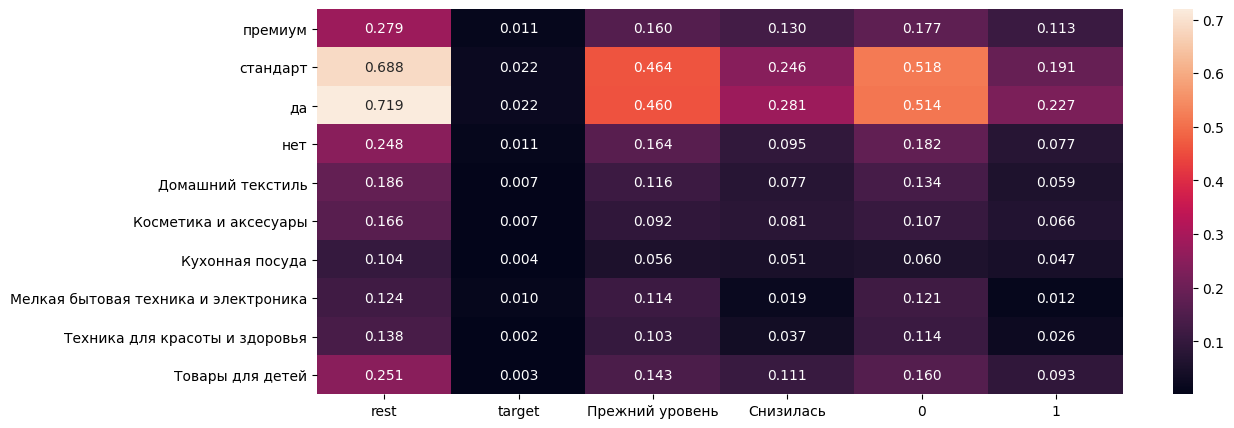

In [134]:
_ = encode_list[1:]
compare_c = compare.head(0)
for c in _:
    segment_pt = pd.pivot_table(data=table, index=['segment'],
                                values=['n_crush'], columns=c, 
                                aggfunc=['count']).T
    activity_pt = pd.pivot_table(data=table, index=['activity'],
                                 values=['n_crush'], columns=c, 
                                 aggfunc=['count']).T
    predict_pt = pd.pivot_table(data=table, index=['predict'],
                                values=['n_crush'], columns=c, 
                                aggfunc=['count']).T
    t = pd.concat([segment_pt, activity_pt, predict_pt], axis=1).fillna(0)
    t.index = t.index.droplevel([0,1])
    compare_c = pd.concat([compare_c,t], axis=0)
compare_c = compare_c/ len(table)
plt.rcParams['figure.figsize'] = (13, 5)
sns.heatmap(compare_c, annot=True, fmt='.3f');

Клиенты целевого сегмента представлены во всех категориях, повышенной концентраци на каком-либо признаке не наблюдается.

In [135]:
def hist_it(param, hi=4):
    colors=['white', 'grey', 'red', 'pink', 'green']
    _bins = max(int(len(table[param].unique())/10) , 10)
    _range = ((min(table[param]),max(table[param])))
    plt.rcParams['figure.figsize'] = (13, hi)
    plt.subplots(nrows=4, ncols=1)
    i=0
    for s in table['segment'].unique():
        i+=1
        plt.subplot(4,1,i)
        plt.xlim(_range)
        plt.xticks([])
        sns.histplot(x=table[table.segment==s][param], 
                     color=colors[i], bins=_bins)
        plt.ylabel('')
        plt.legend([s]);
    for a in table['activity'].unique():
        i+=1
        plt.subplot(4,1,i)
        plt.xlim(_range)
        sns.histplot(x=table[table.activity==a][param], 
                     color=colors[i], bins=_bins)
        plt.ylabel('')
        plt.legend([a]);

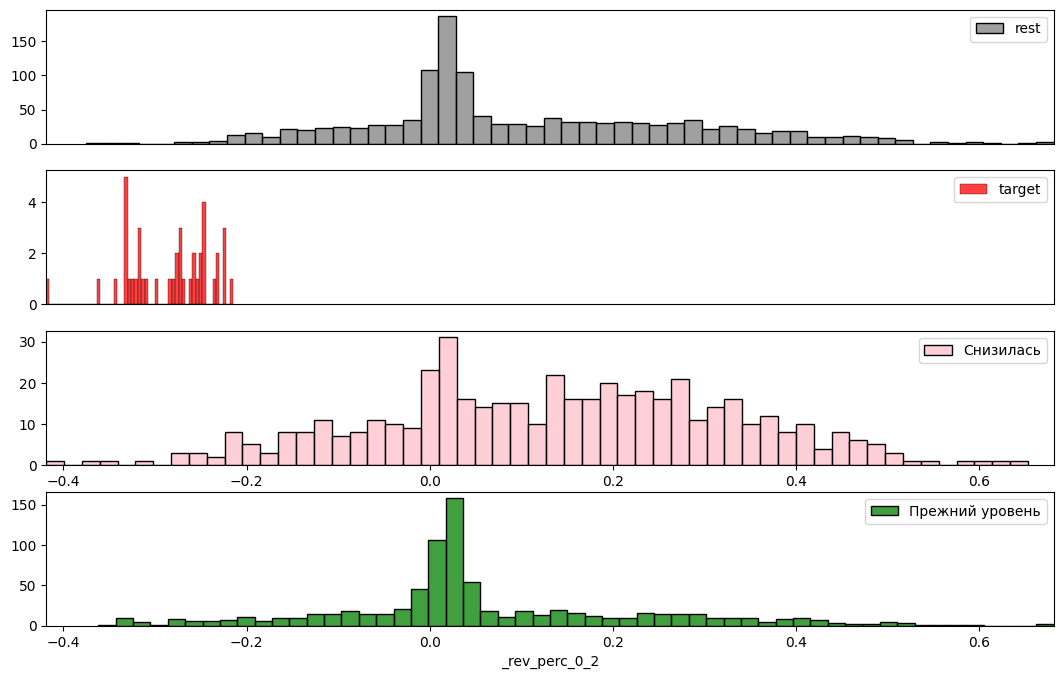

In [136]:
hist_it('_rev_perc_0_2', hi=8)

Именно по изменению Выручки за 2 месяца целевой сегмент значительно отличается от остальной массы клиентов - у всех покупателей снижение Выручки за 2 месяца более чем на 20%.

По другим метрикам (кроме помесячных данных о Выручке) **невозможно корректно оценить снижение** покупательской активности - все данные представлены усреднённые, без динамики. <br>
То есть эти метрики указывают на **низкую** активность на сайте, но так как они представлены усреднёнными показателями за несколько месяцев, мы ничего не можем сказать о динамике этой активности. <br>
Не исключается ситуация, когда у клиента была ещё более низкая активность, может он вообще не заходил на сайт и ничего не покупал, но вдруг начал (вернулся, ведь срок регистрации у всех клиентов приличный) снова покупать, а мы по метрике низкого среднего за 3 месяца маркируем ему "Снижение активности" - такой подход не может считаться корректным. <br> 
Тут как в принципе неопределённости Гейзенберга: Знаем сколько, но не знаем как было раньше...

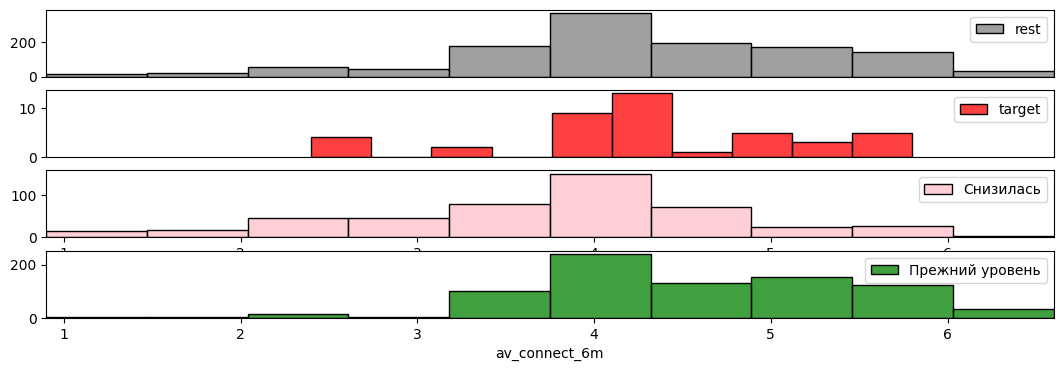

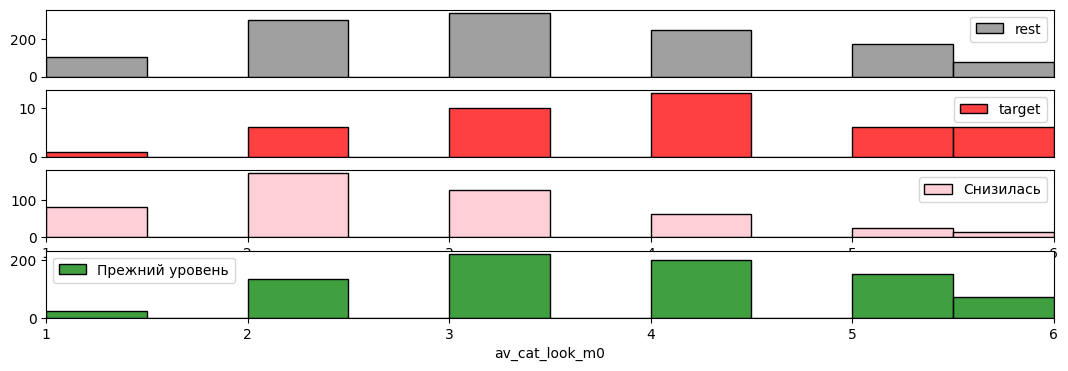

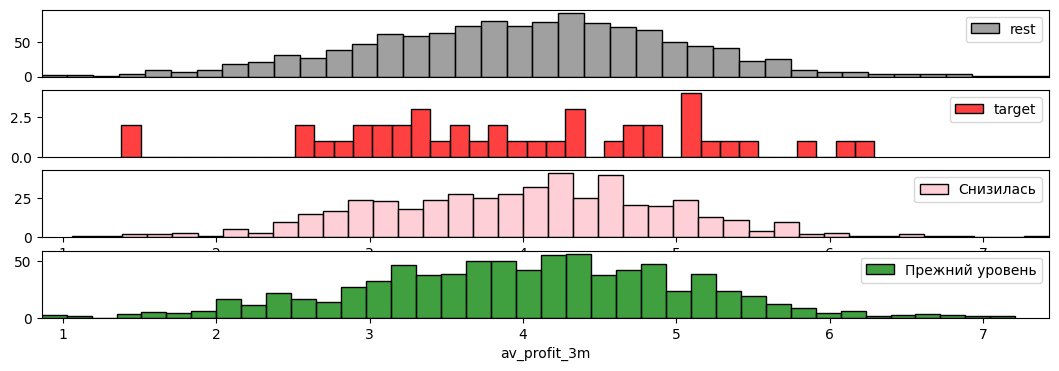

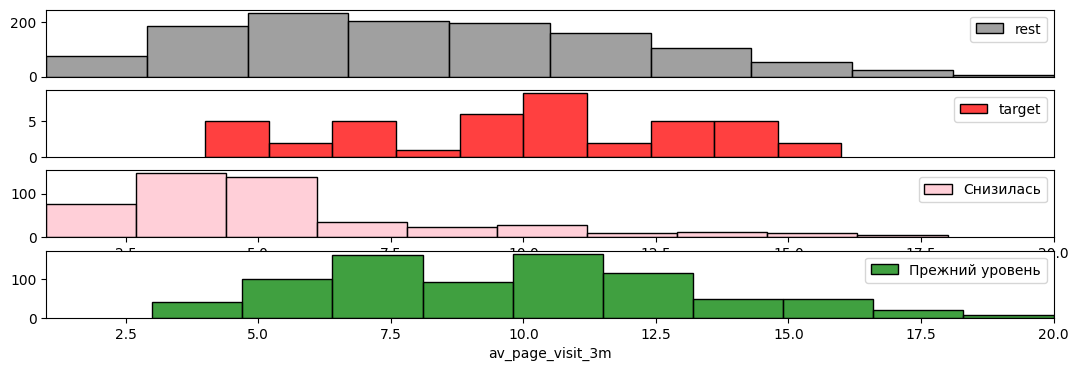

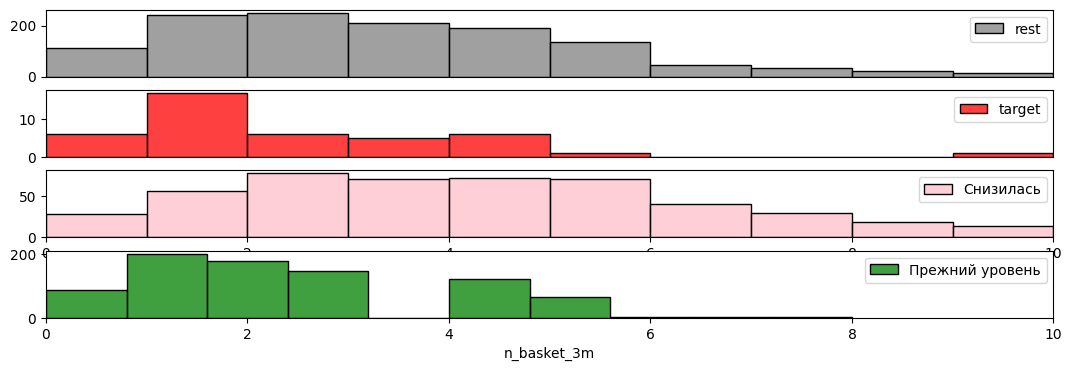

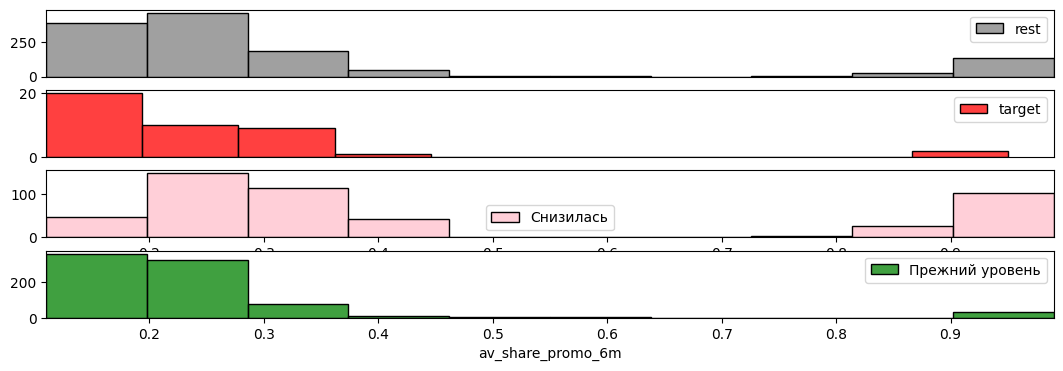

In [137]:
for p in ['av_connect_6m', 'av_cat_look_m0', 'av_profit_3m', 
          'av_page_visit_3m', 'n_basket_3m', 'av_share_promo_6m']:
    hist_it(p)

**Предложения по увеличению покупательской активности группы**: <br>
1. Активнее предлагать клиетам акционные товары, повышать долю акционных покупок;
2. Сразу после оформления заказа показывать интересные им и акционные товары - "добавьте себе в корзину сейчас, а оплатите когда удобно";
3. Разгонять выручку этих клиентов пороговыми скидками/купонами: "При заказе на 5000 Вы получите скидку в -10% на весь заказ".

**Вывод:** <br>
В качестве исследуемого сегмента выделены клиенты, чья выручка каждый (из представленных) месяц снижается более чем на 10%.


## Шаг 9. Общий вывод

Задача проекта: разработать решение, которое позволит персонализировать предложение постоянным клиентам, чтобы увеличить их покупательскую активность. <br>
Подход к решению предложен через подбор модели бинарной классификации, которая самомтоятельно на основе имеющихся метрик промаркирует пользователей по уровню их активности в соответствии с заранее проставленным целевым признаком активности: "прежний уровень" / "снижение".

Исходные данные содержат данные 1300 уникальных клиентов по следующим метрикам:
1. Целевой признак, определённый заранее бинарный уровень покупательской активности;
2. Показатели коммуникации: среднемесячное количество за 6 месяцев и количество в текущем месяце;
3. Показатели Продуктового поведения: среднне количество категорий за визит, среднее количество неоплаченныйх товаров в корзине за квартал, средняя за полгода доля покупок по акции;
4. Показатели поведения на сайте: среднне зв квартал количество просмотренных товаров в 1 визит на сайт, сумма (за всё время) сбоев, которые произошли на сайте в течении визитов пользователя и **время на сайте в текущем и предыдущем месяце**;
5. Финансовые показатели: среднемесячная прибыль за квартал и **Выручка за каждый из трёх последних месяцев**.

В рамках предобработки данные очищены от единичного выброса по Выручке, исправлены опечатки в текстовом поле "уровень сервиса", устранены дубликаты - клиенты с одинаковыми метриками поведения на сайте.

Для поиска лучшей модели бинарной классификации целевого признака применялись различные комбинации кодирования категориальных переменных и два скейлера (стандартизация и нормализация) для количественных признаков. <br>
Тестируемыми моделями были:
- Метод k-ближайших соседей (по трём метрикам расстояний);
- Метод Дерева решений (гиперпараметр максимальной глубины ветвления от 2 до 10);
- Метод опорных векторов SVC (4 варианта ядер);
- Логистическая регрессия (2 метода регуляризации).

С учётом незначительности временных и вычислительных затрат, был пременн сплошной (сеточный) перебор предобработок, моделей и их гиперпараметров.

Метрикой для оценки моделей и определения лучшей была `roc-auc`, как всеохватывающая метрика для моделей классификации и так как в целевом признаке присутствует значимый дисбалланс классов (62/38).

Лучшей моделью с показателем метрики roc-auc = 91% оказалась модель SVC метода опорных векторов. <br>
Модель с хорошей точностью повторяла заданные значения целевого признака на основе значений других параметров данных.

С использованием метода SHAP произведён частичный анализ вклада признаков в результат расчёта классификации лучшей модели. <br>
Из-за значительного объёма тренировочной выборки и количества факторов, расчёт SHAP-значений для  каждого наблюдения занимал чуть меньше минуты, из-за этого расчёт был проведён только для 5 наблюдений. <br>
Тем не менее, расчёт SHAP позволил обозначить значимые для модели признаки:
- количество просматриваемых товаров за визит,
- доля акционных покупок,
- время на сайте,
- количество просматриваемых категорий товаров.

Несмотря на то, что лучшая модель бинарной классификации, обученная на исходно заданном целевом признаке и наборе факторов, повторяла исходную классификацию на 91%, для сегментации клиентской базы её результаты не подходили. <br>
Полученный механизм основывался преимущественно не на динамических факторах (выручка по месяцам, время по месяцам), а большее предпочтение отдавал усреднённым за период показателям: средние просмотры за квартал, средняя доля акционных покупок за полгода и др. <br>
Исследование оакзалось в ловушке подмены понятий: модель акцентировалась не на снижении активности, а на низкой активности - её и фиксировала.

Используя только средние за период показатели невозможно рассуждать о динамике - невозможно определить снижение активности, если метрики статичны. <br>
*Всё равно что рассуждать о скорости автомобиля на дороге по фотографии"* <br>
Поэтому исследуемым сегментом был выбран набор клиентов, чья выручка снижалась более чем на 10% два месяца подряд. <br>
Время на сайте - тоже динамический признак в данных и он тоже как нельзя лучше указывает на активность пользователей, однако: снижение времени на сайте при сохранении выручки может свидетельствовать о том, что сайт перестал зависать, работает быстрее, или о том, что клиент быстрее в нём ориентируется и просто не тратит своё время на нём впустую - просто знает что ему нужно и заказывает. <br>
Поэтому при выделении **сегмента истинного снижения покупательской активности** время на сайте не было использовано как критерий сегментации.

Для восстановления покупательской активности выделенного сегмента предложены маркетинговые приёмы:
1. предлагать акционные товары, дарить персональные промокоды;
2. предлагать после оформления заказа "добавить в корзину сейчас, чтобы не забыть в следующий раз";
3. предлагать "пороговые" промо-акции (при заказе от 5000 будет вам скидка).